GPRL book chapter 8 - Introduction to Value-Based Deep Reinforcement Learning

# Preparation

In [53]:
!apt install imagemagick

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  imagemagick-6.q16 libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libwmflite-0.2-7 netpbm
  poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x imagemagick-doc
  autotrace cups-bsd | lpr | lprng enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer
  povray radiance sane-utils texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev
  inkscape poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nan

In [1]:
import warnings ; warnings.filterwarnings('ignore')
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

LEAVE_PRINT_EVERY_N_SECS = 60
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('.', 'results')
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
params = {
  'figure.figsize': (15, 8),
  'font.size': 24,
  'legend.fontsize': 20,
  'axes.titlesize': 28,
  'axes.labelsize': 24,
  'xtick.labelsize': 20,
  'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
torch.cuda.is_available()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False

# Utils

In [65]:
def get_make_env_fn(**kargs):
  def make_env_fn(env_name,
                  seed=None,
                  render=None,
                  record=False,
                  unwrapped=False,
                  monitor_mode=None, # record video
                  inner_wrappers=None,
                  outer_wrappers=None):
    # tmp_dir = tempfile.mkdtemp()
    env = None
    if render:
      try:
        env = gym.make(env_name, render=render)
      except:
        print(f"error: render={render}")
        pass
    if env is None: env = gym.make(env_name)
    if seed is not None: env.seed(seed)
    env = env.unwrapped if unwrapped else env
    if inner_wrappers:
      for wrapper in inner_wrappers:
        env = wrapper(env)

    env = gym.wrappers.RecordVideo(env, './video_'+monitor_mode
                                   ) if record else env
    # env = wrappers.Monitor(env, tmp_dir, force=True, # override temp file
    #                        mode=monitor_mode,
    #                        video_callable=lambda e_idx: record
    #                        ) if monitor_mode else env
    if outer_wrappers:
      for wrapper in outer_wrappers:
        env = wrapper(env)
    return env
  return make_env_fn, kargs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
make_env_fn, make_env_kargs = get_make_env_fn(env_name="CartPole-v1")

In [66]:
def get_videos_html(env_videos, title, max_n_videos=5):
  '''
  env_videos - list of videos
  title - heading/title of the html heading
  max_n_videos - max number of videos; can be larger or smaller tha len of the env_videos list
  '''
  print(env_videos)
  videos = np.array(env_videos)
  if len(videos) ==0:
    return
  n_videos = max(1, min(max_n_videos, len(videos)))
  idxs = np.linspace(0, len(videos)-1, n_videos).astype(int) if n_videos>1 else [-1,]
  videos = videos[idxs, ...]

  strm = f'<h2>{title}</h2>'
  for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)

    with open(meta_path) as data_file:
      meta = json.load(data_file)

    html_tag=f"""
    <h3>Episode {meta['episode_id']}</h3>
    <video width="960" height="540" controls>
      <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4"/>
    </video>
    """
    strm += html_tag
  return strm


In [67]:
def get_gif_html(env_videos, title, subtitle_eps=None, max_n_videos=4):
  videos = np.array(env_videos)
  if len(videos) == 0:
    return

  n_videos = max(1, min(max_n_videos, len(videos)))
  idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
  videos = videos[idxs,...]

  strm = '<h2>{}<h2>'.format(title)
  for video_path, meta_path in videos:
    basename = os.path.splitext(video_path)[0]
    gif_path = basename + '.gif'
    if not os.path.exists(gif_path):
      ps = subprocess.Popen(
        ('ffmpeg',
          '-i', video_path,
          '-r', '7',
          '-f', 'image2pipe',
          '-vcodec', 'ppm',
          '-crf', '20',
          '-vf', 'scale=512:-1',
          '-'),
        stdout=subprocess.PIPE)
      output = subprocess.check_output(
        ('convert',
          '-coalesce',
          '-delay', '7',
          '-loop', '0',
          '-fuzz', '2%',
          '+dither',
          '-deconstruct',
          '-layers', 'Optimize',
          '-', gif_path),
        stdin=ps.stdout)
      ps.wait()

    gif = io.open(gif_path, 'r+b').read()
    encoded = base64.b64encode(gif)

    with open(meta_path) as data_file:
        meta = json.load(data_file)

    html_tag = """
    <h3>{0}<h3/>
    <img src="data:image/gif;base64,{1}" />"""
    prefix = 'Trial ' if subtitle_eps is None else 'Episode '
    sufix = str(meta['episode_id'] if subtitle_eps is None \
                else subtitle_eps[meta['episode_id']])
    strm += html_tag.format(prefix + sufix, encoded.decode('ascii'))
  return strm

In [7]:
class DiscountedCartPole(gym.Wrapper):
  def __init__(self, env):
    gym.Wrapper.__init__(self, env)

  def reset(self, **kwargs):
    return self.env.reset(**kwargs)

  def step(self, a):
    # step returns observation, reward, terminated, truncated, info
    o, r, d, _ = self.env.step(a)
    (x, x_dot, theta, theta_dot) = o
    pole_fell = x < -self.env.unwrapped.x_threshold \
      or x > self.env.unwrapped.x_threshold \
      or theta < -self.env.unwrapped.theta_threshold_radians \
      or theta > self.env.unwrapped.theta_threshold_radians
    r = -1 if pole_fell else 0
    return o, r, d, _

# NFQ
Neural Fitted Q Iteration (NFQ), one of the 1st neuro-net algo for reinforcment learning. It approximates action-value function - estimated as Q(s,a; θ).

The architecture we use for cart pole is State-in-values-out:
* input = state variables s: cart position, velocity, pole angle, velocity at tip
* output = vector of values Q(s): one for each action

In [8]:
# fully connected Q-function (state-in-values-out)
class FCQ(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
    super(FCQ, self).__init__()
    self.activation_fc = activation_fc

    self.input_layer = nn.Linear(input_dim, hidden_dims[0])
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
    self.device = torch.device(device)
    self.to(self.device)

  def _format(self, state):
    """
    state: is a list of state variables, cart position, velocity, etc.
    """
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, device=self.device, dtype=torch.float32)
      x = x.unsqueeze(0)
    return x

  def forward(self, state):
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))
    x = self.output_layer(x)
    return x

  def numpy_float_to_device(self, variable):
    variable = torch.from_numpy(variable).float().to(self.device)
    return variable

  def load(self, experiences):
    states, actions, rewards, new_states, is_terminals = experiences
    states = torch.from_numpy(states).float().to(self.device)
    actions = torch.from_numpy(actions).long().to(self.device)
    new_states = torch.from_numpy(new_states).float().to(self.device)
    rewards = torch.from_numpy(rewards).float().to(self.device)
    is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
    return states, actions, rewards, new_states, is_terminals


## selecting an exploration strategy

Any techniques from chapter 4 for exploration-exploitation tradeoff will be fine. To keep it simple, we use an epsilon-greedy strategy on our NFQ implementation.

But we are trining an off-policy learning algo, i.e. there are two policies:
* a policy that generates behaviour, which in this case is an ϵ-greedy policy
* a policy that we are learning about, which is the greedy (an ultimately optimal) policy.

In [9]:
class GreedyStrategy():
  def __init__(self):
    self.exploratory_action_taken = False

  def select_action(self, model, state):
    with torch.no_grad():
      q_values = model(state).cpu().detach().data.numpy().squeeze()
      return np.argmax(q_values)

In [10]:
class EGreedyStrategy():
  def __init__(self, epsilon=0.1):
    self.epsilon = epsilon
    self.exploratory_action_taken = None

  def select_action(self, model, state):
    self.exploratory_action_taken = False
    with torch.no_grad():
      q_values = model(state).cpu().detach().data.numpy().squeeze()

    if np.random.rand() > self.epsilon:
      action = np.argmax(q_values)
    else:
      action = np.random.randint(len(q_values))

    self.exploratory_action_taken = action != np.argmax(q_values)
    return action

In NFQ, we used epsilon greedy with a constant value of 0.5. Yes! That is 50% of the time we acted greedily, and 50% of the time, we chose uniformly at random. Given that there are only two actions in this environment, the actual probability of choosing the greedy action is 75%, and the chance of selecting the non-greedy action is 25%. Notice
that in large action space, the probability of selecting the greedy action would be smaller.

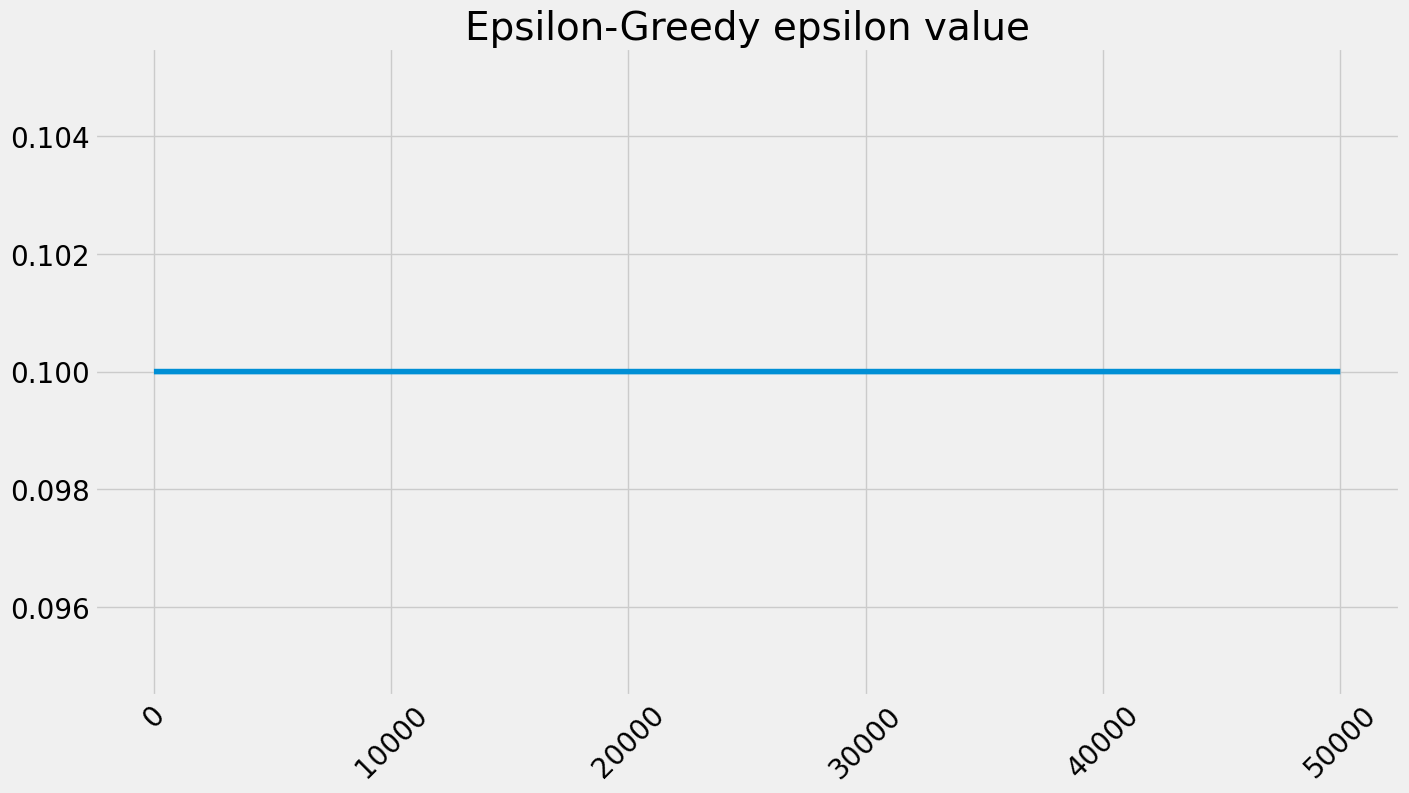

In [11]:
s = EGreedyStrategy()
plt.plot([s.epsilon for _ in range(50000)])
plt.title('Epsilon-Greedy epsilon value')
plt.xticks(rotation=45)
plt.show()

In [12]:
class EGreedyLinearStrategy():
  def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
    self.t = 0 # timestep
    self.epsilon = init_epsilon
    self.init_epsilon = init_epsilon
    self.min_epsilon = min_epsilon
    self.decay_steps = decay_steps
    self.exploratory_action_taken = None

  def _epsilon_update(self):
    epsilon = 1 - self.t / self.decay_steps
    epsilon = (self.init_epsilon - self.min_epsilon) * epsilon + self.min_epsilon
    epsilon = np.clip(epsilon, self.min_epsilon, self.init_epsilon)
    self.t += 1
    return epsilon

  def select_action(self, model, state):
    self.exploratory_action_taken = False
    with torch.no_grad():
      q_values = model(state).cpu().detach().data.numpy().squeeze()

    if np.random.rand() > self.epsilon:
      action = np.argmax(q_values)
    else:
      action = np.random.randint(len(q_values))

    self.epsilon = self._epsilon_update()
    self.exploratory_action_taken = action != np.argmax(q_values)
    return action

In DQN and all remaining value-based algorithms here, I use the exponentially decaying epsilon-greedy strategy because it is simple and it works well. But other, more advanced strategies may be worth trying. I noticed even a small difference in hyperparameters makes a significant difference in performance.

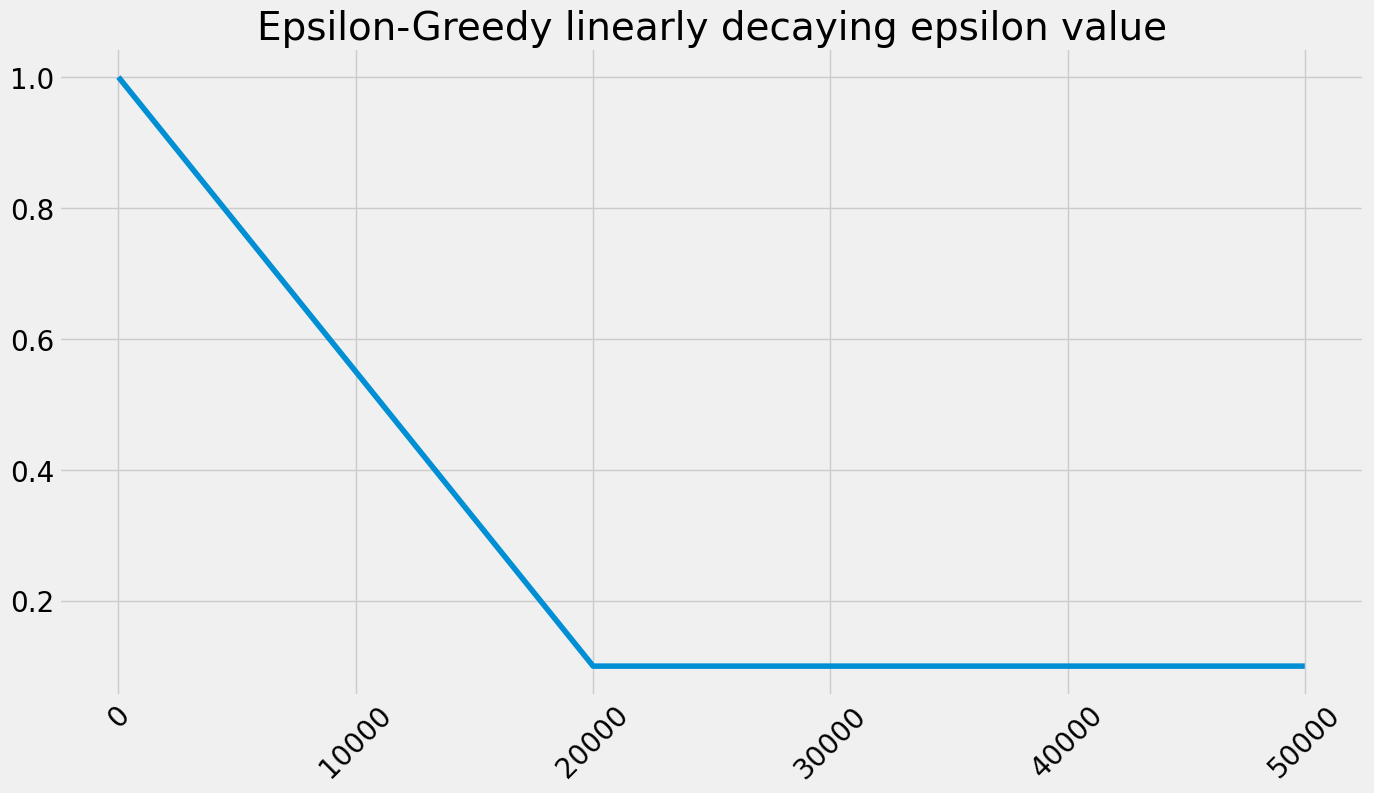

In [13]:
s = EGreedyLinearStrategy()
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('Epsilon-Greedy linearly decaying epsilon value')
plt.xticks(rotation=45)
plt.show()

In [14]:
class EGreedyExpStrategy():
  def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
    self.epsilon = init_epsilon
    self.init_epsilon = init_epsilon
    self.decay_steps = decay_steps
    self.min_epsilon = min_epsilon
    self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
    self.t = 0
    self.exploratory_action_taken = None

  def _epsilon_update(self):
    self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
    self.t += 1
    return self.epsilon

  def select_action(self, model, state):
    self.exploratory_action_taken = False
    with torch.no_grad():
      q_values = model(state).detach().cpu().data.numpy().squeeze()

    if np.random.rand() > self.epsilon:
      action = np.argmax(q_values)
    else:
      action = np.random.randint(len(q_values))

    self._epsilon_update()
    self.exploratory_action_taken = action != np.argmax(q_values)
    return action

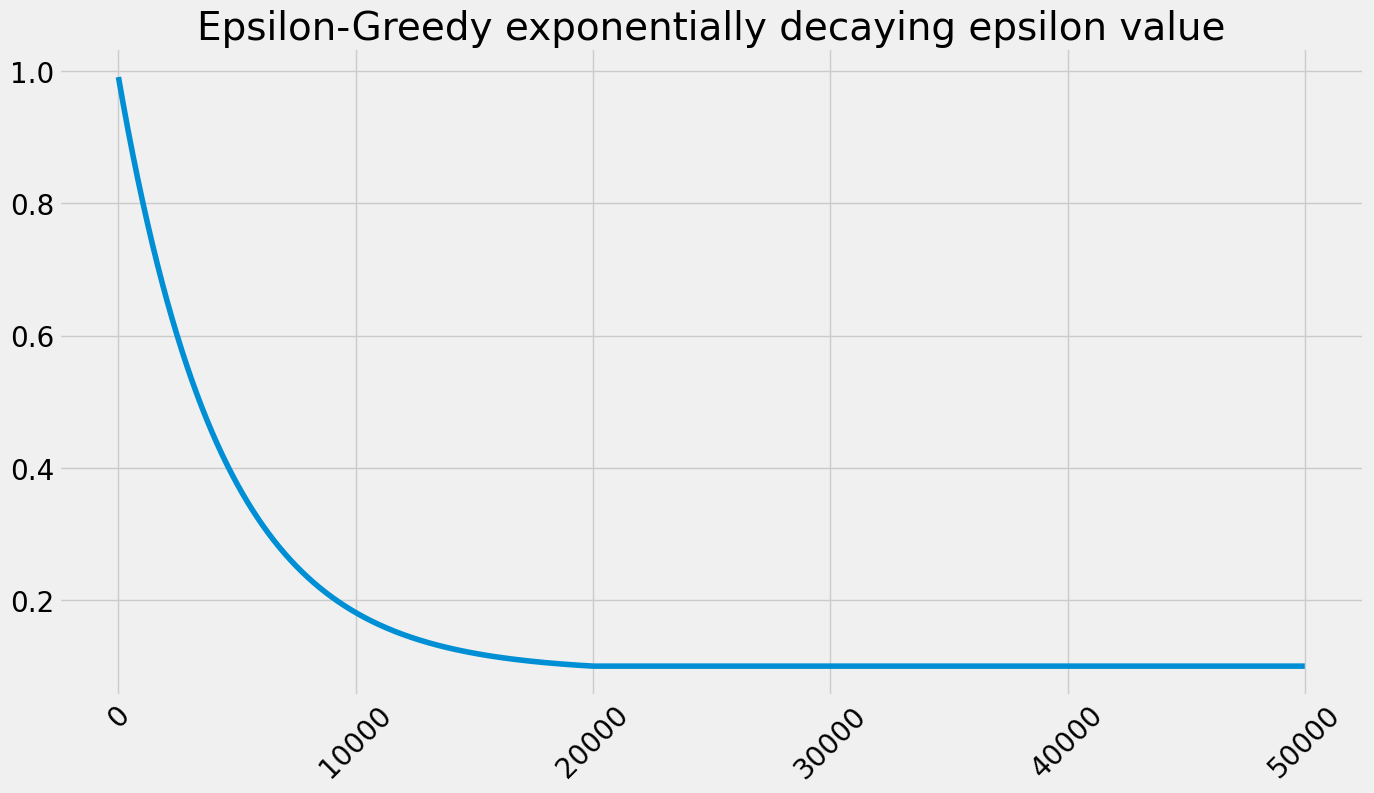

In [15]:
s = EGreedyExpStrategy()
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('Epsilon-Greedy exponentially decaying epsilon value')
plt.xticks(rotation=45)
plt.show()

In [16]:
class SoftMaxStrategy():
  def __init__(self, init_temp=1.0, min_temp=0.3, exploration_ratio=0.8, max_steps=25000):
    self.t = 0
    self.init_temp = init_temp
    self.exploration_ratio = exploration_ratio
    self.min_temp = min_temp
    self.max_steps = max_steps
    self.exploratory_action_taken = None

  # in SoftMax strategy, we use 'temperature' parameter: the closer to 0,
  # the more pronounced the differences in the values will become, making
  # action selection more 'greedy'. The temperatur is decayed linearly.
  def _update_temp(self):
    temp = 1 - self.t / (self.max_steps * self.exploration_ratio)
    temp = (self.init_temp - self.min_temp) * temp + self.min_temp
    temp = np.clip(temp, self.min_temp, self.init_temp)
    self.t += 1
    return temp

  def select_action(self, model, state):
    self.exploratory_action_taken = False
    temp = self._update_temp()

    with torch.no_grad():
      q_values = model(state).cpu().detach().data.numpy().squeeze()
      # scaling and normalising the q-values
      scaled_qs = q_values / temp
      norm_qs = scaled_qs - scaled_qs.max()
      e = np.exp(norm_qs)
      probs = e / np.sum(e)
      assert np.isClose(probs.sum(), 1.0)

    action = np.random.coice(np.arange(len(probs)), size=1, p=probs)[0]
    self.exploratory_action_taken = action != np.argmax(q_values)
    return action

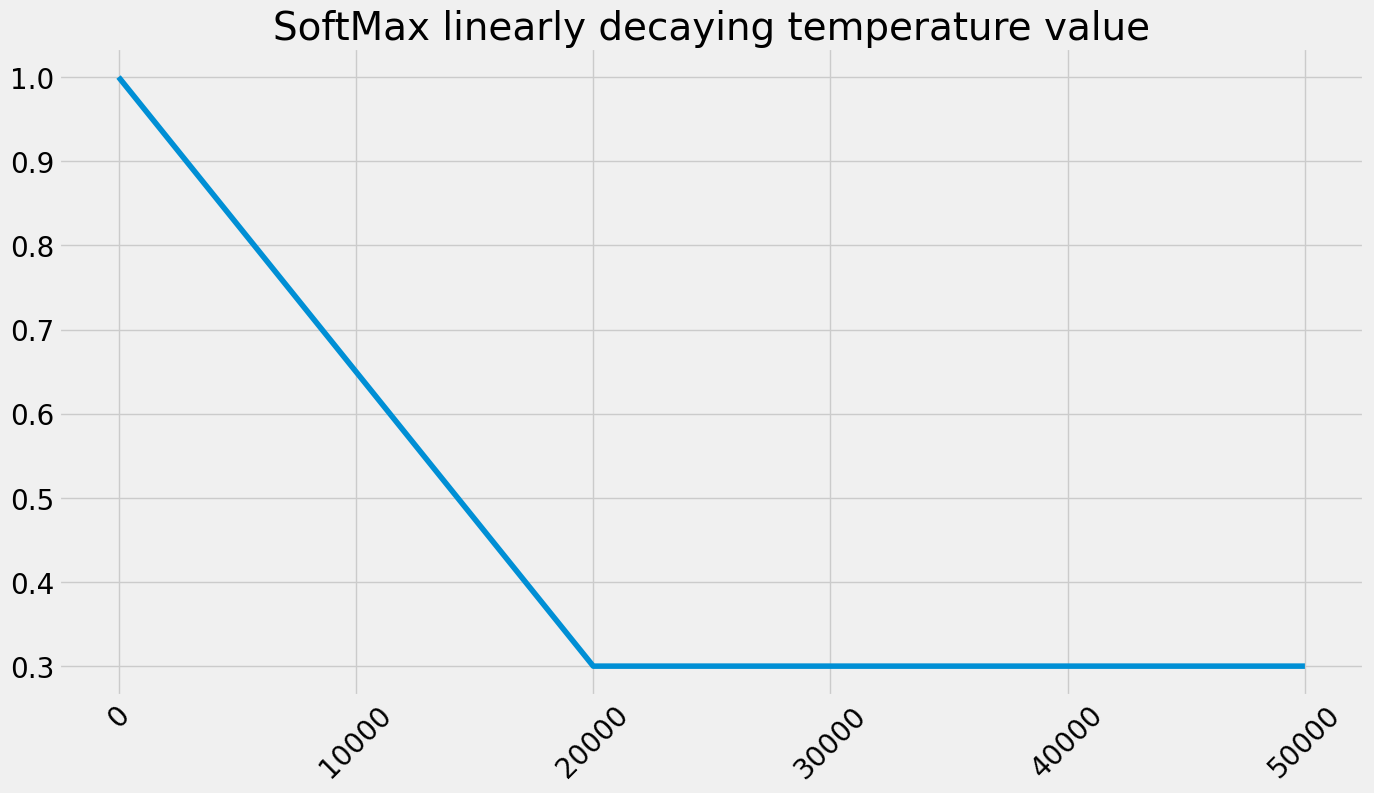

In [17]:
s = SoftMaxStrategy()
plt.plot([s._update_temp() for _ in range(50000)])
plt.title('SoftMax linearly decaying temperature value')
plt.xticks(rotation=45)
plt.show()

## selecting what to optimise
An ideal objective in value-based DRL would be to minimise the loss w.r.t. the optimal action-value function q⋆.
$$L_i(θ_i)=\mathbb{E}_{s,a}\left[\left(q_*(s,a)-Q(s,a;\theta_i)\right)^2\right]
$$
Because we'd like to have an estimate of q*, Q, that tracks exactly that optimal function, if we had a solid estimate of q*, we then could use a greedy action w.r.t. these estimates to get near optimal behaviour.

Refesh the definition of optimal action=value function q⋆:
$$q_*(s,a)=\max_{π}\mathbb{E}_π\left[G_t|S_t=s, A_t=a\right], ∀s∈S,∀a\in A(s)
$$
The optimal action-value function q⋆ is the poicy π that gives the maximum expected return from each and every action in each and every state.

For our NFQ implementation, we start with a randomly initialised q function (and implicit policy). Then evaluate the policy by sampling actions from it, same as chapter 5. Then iprove it with an exploration strategy such as epsilon-greedy, like in chapter 4. Finally, keep iterating until we reach the desired peformance, as in chapters 6 and 7.

## selecting targets for policy evaluation
Out of MC, TD, N-step, Lambda targets, any one would do. For simplicity we choose TD target.

TD targets can be either
* on-policy: Sarsa target for on-policy bootstrapping - use the action-value function of the action the agent will take at the landing state; the target would be approximatin gthe behavioural policy, i.e. the policy-generating behaviour and the policy being learned would be the same.
* off-policy: Q-learning for off-policy bootstrapping - use the value of the best action at the next state; we always approximate the greedy poicy, even if the policy-generating behaviour is not totally greedy.
$$
y_{i}^{Sarsa}=R_{t+1}+γQ(S_{t+1},A_{t+1};θ_i)
$$
$$
y_{i}^{Q-learning}=R_{t+1}+γ\max_{a}Q(S_{t+1},a;θ_i)
$$

In our NFQ implemenation, we will use the off-policy TD target. Substituting $y_i^{Q-learning}$ into the above loss function $L_i$:
$$L_i(θ_i)=\mathbb{E}_{s,a,r,s'}\left[\left(r+γ\max_{a'}Q(s',a';θ_i)-Q(s,a;\theta_i)\right)^2\right]
$$

Notice that when differentiating througth this equation, the gradiet does not involve the target y, the gradient must only go through the predicted value Q:
$$
∇_{θ_i} L_i(θ_i)=\mathbb{E}_{s,a,r,s'}\left[\left(r+γ\max_{a'}Q(s',a';θ_i)-Q(s,a;\theta_i)\right)\nabla_{θ_i}Q(s,a;\theta_i)\right]
$$

## select loss function
We use MSE (or L2 loss) - in the code below optimize_model().

The loss function measures the distance between predicted values (of the Q-function, coming from the neuro-net) and 'true values' (TD targets, which depend on a prediction also coming from the network, the value of next state). So there is a circular dependency of the action-value function.

In [49]:
class NFQ():
  def __init__(self,
               value_model_fn,
               value_optimizer_fn,
               value_optimizer_lr,
               training_strategy_fn,
               evaluation_strategy_fn,
               batch_size,
               epochs):
    self.value_model_fn = value_model_fn
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr
    self.training_strategy_fn = training_strategy_fn
    self.evaluation_strategy_fn = evaluation_strategy_fn
    self.batch_size = batch_size
    self.epochs = epochs


  def optimize_model(self, experiences):
    states, actions, rewards, next_states, is_terminals = experiences
    batch_size = len(is_terminals)

    # we get the values of Q-function at s_prime (next_state).
    # 'next_states' is plural because it's a batch of 'next_state'.
    # detach() here becasue we don't propagate values through this, this keeps
    # the predicted vlaue a constant since we only use it to calculate targets.
    # q_sa = self.online_model(next_states).detach()
    max_a_q_sp = self.online_model(next_states).detach().max(1)[0].unsqueeze(1)
    # *(1-is_terminals) to ensure terminal states are grounded to zero.
    target_q_s = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)

    # get the current estimate of Q(s,a).
    q_sa = self.online_model(states).gather(1, actions)

    td_errors = target_q_s - q_sa
    value_loss = td_errors.pow(2).mul(0.5).mean()
    # back prop
    self.value_optimizer.zero_grad()
    value_loss.backward()
    self.value_optimizer.step()

  def interaction_step(self, state, env):
    action = self.training_strategy.select_action(self.online_model, state)
    new_state, reward, is_terminal, info = env.step(action)
    # the cart-pole env has a wrapper that artificially teminates an episode after
    # some time steps. So we add extra code to check this.
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    is_failure = is_terminal and not is_truncated
    experience = (state, action, reward, new_state, float(is_failure))

    self.experiences.append(experience)
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
    return new_state, is_terminal

  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):
    training_start, last_debug_time = time.time(), float('-inf')

    self.checkpoint_dir = tempfile.mkdtemp()
    print(f'checkpoint_dir: {self.checkpoint_dir}')
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    nS, nA = env.observation_space.shape[0], env.action_space.n
    self.episode_timestep = []
    self.episode_reward = []
    self.episode_seconds = []
    self.evaluation_scores = []
    self.episode_exploration = []

    self.online_model = self.value_model_fn(nS, nA)
    self.value_optimizer = self.value_optimizer_fn(self.online_model,
                                                   self.value_optimizer_lr)

    self.training_strategy = training_strategy_fn()
    self.evaluation_strategy = evaluation_strategy_fn()
    self.experiences = []

    # the 5 dim are: total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed
    result = np.empty((max_episodes, 5))
    result[:] = np.nan
    training_time = 0
    for episode in range(1, max_episodes+1):
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      self.episode_reward.append(0.0)
      self.episode_timestep.append(0.0)
      self.episode_exploration.append(0.0)

      for step in count(): # starting from 0
        state, is_terminal = self.interaction_step(state, env)
        # self.experiences is appended by self.interaction_step()

        if len(self.experiences) >= self.batch_size:
          experiences = np.array(self.experiences, dtype=object)
          batches = [np.vstack(sars) for sars in experiences.T]
          experiences = self.online_model.load(batches)
          for _ in range(self.epochs):
            self.optimize_model(experiences)
          self.experiences.clear()

        if is_terminal:
          gc.collect()
          break

      # stats
      episode_elapsed = time.time() - episode_start
      self.episode_seconds.append(episode_elapsed)
      training_time += episode_elapsed
      evaluation_score, _ = self.evaluate(self.online_model, env)
      self.save_checkpoint(episode-1, self.online_model)

      total_step = int(np.sum(self.episode_timestep))
      self.evaluation_scores.append(evaluation_score)

      mean_10_reward = np.mean(self.episode_reward[-10:])
      std_10_reward = np.std(self.episode_reward[-10:])

      mean_100_reward = np.mean(self.episode_reward[-100:])
      std_100_reward = np.std(self.episode_reward[-100:])

      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      std_100_eval_score = np.std(self.evaluation_scores[-100:])

      lst_100_exp_rat = np.array(self.episode_exploration[-100:]) \
        / np.array(self.episode_timestep[-100:])
      mean_100_exp_rat = np.mean(lst_100_exp_rat)
      std_100_exp_rat = np.std(lst_100_exp_rat)

      wallclock_elapsed = time.time() - training_start
      result[episode-1] = total_step, mean_100_reward, \
        mean_100_eval_score, training_time, wallclock_elapsed

      reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
      reached_max_minutes = wallclock_elapsed >= max_minutes * 60
      reached_max_episodes = episode >= max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
      training_is_over = reached_max_minutes or reached_max_episodes \
        or reached_goal_mean_reward

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      print(debug_message, end='\r', flush=True)
      if reached_debug_time or training_is_over:
        print(ERASE_LINE + debug_message, flush=True)
        last_debug_time = time.time()
      if training_is_over: # print crosses and ticks
        if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
        if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
        if reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')
        break # break out of for step in count() loop

    final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
    wallclock_time = time.time() - training_start
    print('Training complete.')
    print(f'Final evaluation score {final_eval_score:.2f}\u00B1{score_std:.2f}'\
          ' in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.\n')
    env.close(); del env
    self.get_cleaned_checkpoints()
    return result, final_eval_score, training_time, wallclock_time

  def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        a = self.evaluation_strategy.select_action(eval_policy_model, s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int16)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix


    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.online_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.online_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_videos_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.online_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.online_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_videos_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        #subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))

## select an Optimization method
Gradient descent is a stable optimisation method given the following assumptions:
1. IID assumption - Idependent and Identically Distributed.
2. targets are stationary.

However, in RL, the above assumptions don't hold. In practice, both Adam (Adaptive movement estimation) and RMSprop are sensible choices for value-based DRL methods.

NFQ has 3 main steps:
1. collect E experiences: (s, a, r, s', d) tuples. We use 1024 samples. This is batch_size in code
2. calculate the off-policy TD targets: $r+γ\max_{a'}Q(s',a';θ)$
3. fit the action-value function Q(s,a;θ): using MSE and RMSprop

The algo repeats steps 2 and 3 $K$ number of times before going back to step 1. That's what makes it 'fitted'; the nested loop. We will use 40 fitting steps $K$. This is epoch in code.

# Train NFQ

In [50]:
nfq_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
      'env_name': 'CartPole-v1',
      'gamma': 1.00,
      'max_minutes': 20,
      'max_episodes': 10000,
      'goal_mean_100_reward': 475
  }

  value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512, 128))
  value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
  value_optimizer_lr = 5e-4

  training_strategy_fn = lambda: EGreedyStrategy(epsilon=0.5) # or 0.05
  evaluation_strategy_fn = lambda: GreedyStrategy()

  batch_size = 1024
  epochs = 40

  env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = NFQ(value_model_fn,
              value_optimizer_fn,
              value_optimizer_lr,
              training_strategy_fn,
              evaluation_strategy_fn,
              batch_size,
              epochs)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallcock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward
  )
  nfq_results.append(result)
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent

nfq_results = np.array(nfq_results)
_ = BEEP()


checkpoint_dir: /tmp/tmp2ocqng30


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


el 00:00:00, ep 0000, ts 000017, ar 10 017.0±000.0, 100 017.0±000.0, ex 100 0.4±0.0, ev 009.0±000.0
el 00:01:00, ep 0312, ts 005830, ar 10 012.6±002.0, 100 013.2±004.0, ex 100 0.2±0.1, ev 009.7±001.0
el 00:02:00, ep 0616, ts 011340, ar 10 026.9±014.4, 100 021.1±008.9, ex 100 0.2±0.1, ev 019.2±005.5
el 00:03:00, ep 0881, ts 023466, ar 10 021.9±005.9, 100 039.5±044.6, ex 100 0.2±0.1, ev 062.7±082.7
el 00:04:00, ep 1152, ts 032927, ar 10 017.2±005.8, 100 040.2±031.2, ex 100 0.3±0.1, ev 093.4±033.9
el 00:05:00, ep 1424, ts 042364, ar 10 040.9±035.7, 100 033.7±027.6, ex 100 0.3±0.1, ev 082.8±047.2
el 00:06:00, ep 1685, ts 053530, ar 10 072.3±041.7, 100 034.8±027.8, ex 100 0.3±0.1, ev 063.3±038.8
el 00:07:00, ep 1937, ts 066506, ar 10 030.5±014.6, 100 041.4±033.8, ex 100 0.2±0.1, ev 070.1±045.8
el 00:08:00, ep 2132, ts 086219, ar 10 108.1±038.6, 100 105.6±049.0, ex 100 0.3±0.1, ev 211.2±089.0
el 00:09:01, ep 2329, ts 106599, ar 10 135.2±065.5, 100 110.9±062.6, ex 100 0.3±0.1, ev 242.7±100.7


Above debug messages:
* el = elapsed time
* ep = episode
* ts = total steps
* ar 10 = last 10 reward mean, std
* 100 = last 100 reward mean, std
* ex = last 100 exploration ratio mean, std
* ev = last 100 eval score mean, std

In [51]:
best_agent.demo_progression()

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: http

[('./video_prog/rl-video-episode-0.mp4', './video_prog/rl-video-episode-0.meta.json'), ('./video_prog/rl-video-episode-1.mp4', './video_prog/rl-video-episode-1.meta.json')]


In [52]:
best_agent.demo_last()

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecate

[('./video_last/rl-video-episode-0.mp4', './video_last/rl-video-episode-0.meta.json'), ('./video_last/rl-video-episode-1.mp4', './video_last/rl-video-episode-1.meta.json')]


In [201]:
nfq_max_t, nfq_max_r, nfq_max_s, nfq_max_sec, nfq_max_rt = np.max(nfq_results, axis=0).T
nfq_min_t, nfq_min_r, nfq_min_s, nfq_min_sec, nfq_min_rt = np.min(nfq_results, axis=0).T
nfq_mean_t, nfq_mean_r, nfq_mean_s, nfq_mean_sec, nfq_mean_rt = np.mean(nfq_results, axis=0).T
nfq_x = np.arange(len(nfq_mean_s))

In [203]:
nfq_root_dir = os.path.join(RESULTS_DIR, 'nfq')
not os.path.exists(nfq_root_dir) and os.makedirs(nfq_root_dir)

np.save(os.path.join(nfq_root_dir, 'x'), nfq_x)

np.save(os.path.join(nfq_root_dir, 'max_r'), nfq_max_r)
np.save(os.path.join(nfq_root_dir, 'min_r'), nfq_min_r)
np.save(os.path.join(nfq_root_dir, 'mean_r'), nfq_mean_r)

np.save(os.path.join(nfq_root_dir, 'max_s'), nfq_max_s)
np.save(os.path.join(nfq_root_dir, 'min_s'), nfq_min_s )
np.save(os.path.join(nfq_root_dir, 'mean_s'), nfq_mean_s)

np.save(os.path.join(nfq_root_dir, 'max_t'), nfq_max_t)
np.save(os.path.join(nfq_root_dir, 'min_t'), nfq_min_t)
np.save(os.path.join(nfq_root_dir, 'mean_t'), nfq_mean_t)

np.save(os.path.join(nfq_root_dir, 'max_sec'), nfq_max_sec)
np.save(os.path.join(nfq_root_dir, 'min_sec'), nfq_min_sec)
np.save(os.path.join(nfq_root_dir, 'mean_sec'), nfq_mean_sec)

np.save(os.path.join(nfq_root_dir, 'max_rt'), nfq_max_rt)
np.save(os.path.join(nfq_root_dir, 'min_rt'), nfq_min_rt)
np.save(os.path.join(nfq_root_dir, 'mean_rt'), nfq_mean_rt)

# Load from files

In [33]:
!rm -f results/nfq/*
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_r.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_rt.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_s.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_sec.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_t.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_r.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_rt.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_s.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_sec.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_t.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/min_r.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/min_rt.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/min_s.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/min_sec.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/min_t.npy
!wget -nv -P results/nfq https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/x.npy

2024-12-26 22:45:02 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_r.npy [80128/80128] -> "results/nfq/max_r.npy" [1]
2024-12-26 22:45:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_rt.npy [80128/80128] -> "results/nfq/max_rt.npy" [1]
2024-12-26 22:45:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_s.npy [80128/80128] -> "results/nfq/max_s.npy" [1]
2024-12-26 22:45:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_sec.npy [80128/80128] -> "results/nfq/max_sec.npy" [1]
2024-12-26 22:45:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_t.npy [80128/80128] -> "results/nfq/max_t.npy" [1]
2024-12-26 22:45:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_r.npy [80128/80128] -> "results/nfq/mean_r.npy" [1]
2024-12-26 22:45:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/

In [39]:
nfq_root_dir = os.path.join(RESULTS_DIR, 'nfq')
nfq_x = np.load(os.path.join(nfq_root_dir, 'x.npy'))

nfq_max_r = np.load(os.path.join(nfq_root_dir, 'max_r.npy'))
nfq_min_r = np.load(os.path.join(nfq_root_dir, 'min_r.npy'))
nfq_mean_r = np.load(os.path.join(nfq_root_dir, 'mean_r.npy'))

nfq_max_s = np.load(os.path.join(nfq_root_dir, 'max_s.npy'))
nfq_min_s = np.load(os.path.join(nfq_root_dir, 'min_s.npy'))
nfq_mean_s = np.load(os.path.join(nfq_root_dir, 'mean_s.npy'))

nfq_max_t = np.load(os.path.join(nfq_root_dir, 'max_t.npy'))
nfq_min_t = np.load(os.path.join(nfq_root_dir, 'min_t.npy'))
nfq_mean_t = np.load(os.path.join(nfq_root_dir, 'mean_t.npy'))

nfq_max_sec = np.load(os.path.join(nfq_root_dir, 'max_sec.npy'))
nfq_min_sec = np.load(os.path.join(nfq_root_dir, 'min_sec.npy'))
nfq_mean_sec = np.load(os.path.join(nfq_root_dir, 'mean_sec.npy'))

nfq_max_rt = np.load(os.path.join(nfq_root_dir, 'max_rt.npy'))
nfq_min_rt = np.load(os.path.join(nfq_root_dir, 'min_rt.npy'))
nfq_mean_rt = np.load(os.path.join(nfq_root_dir, 'mean_rt.npy'))

# Plotting NFQ

## Training Moving Average Reward
Notice that the training reward never reaches the max of 500-reward per episode. The reason is we are using an epsilon of 0.5. Having such high exploration rate helps with finding more accurate value functions but it shows worse performance during training.

Text(0.5, 0, 'Episodes')

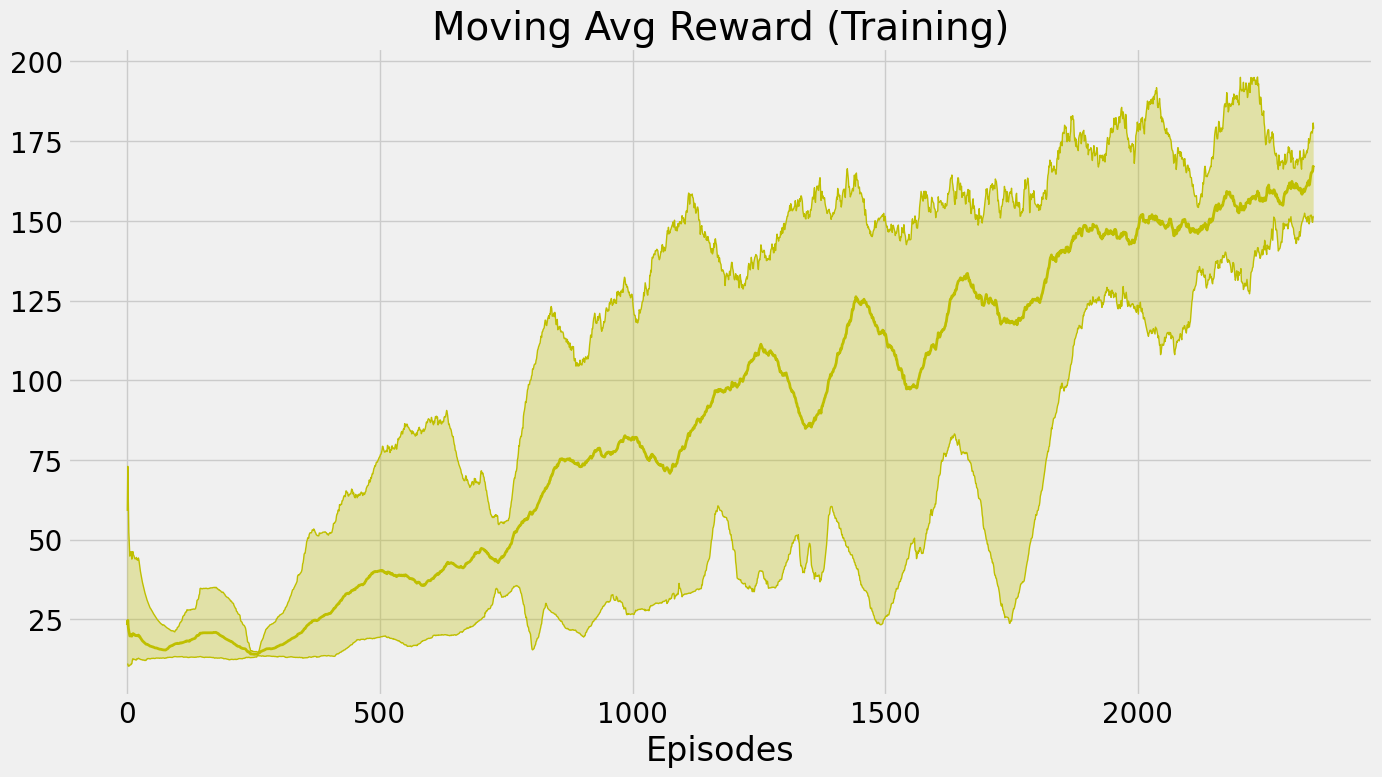

In [43]:
plt.plot(nfq_max_r, 'y', linewidth=1)
plt.plot(nfq_min_r, 'y', linewidth=1)
plt.plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
plt.fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)
plt.title('Moving Avg Reward (Training)')
plt.xlabel('Episodes')

## Evaluation Moving Average Reward
The evaluation steps ar ethe best performance we can obtain from the agent.

Text(0.5, 0, 'Episodes')

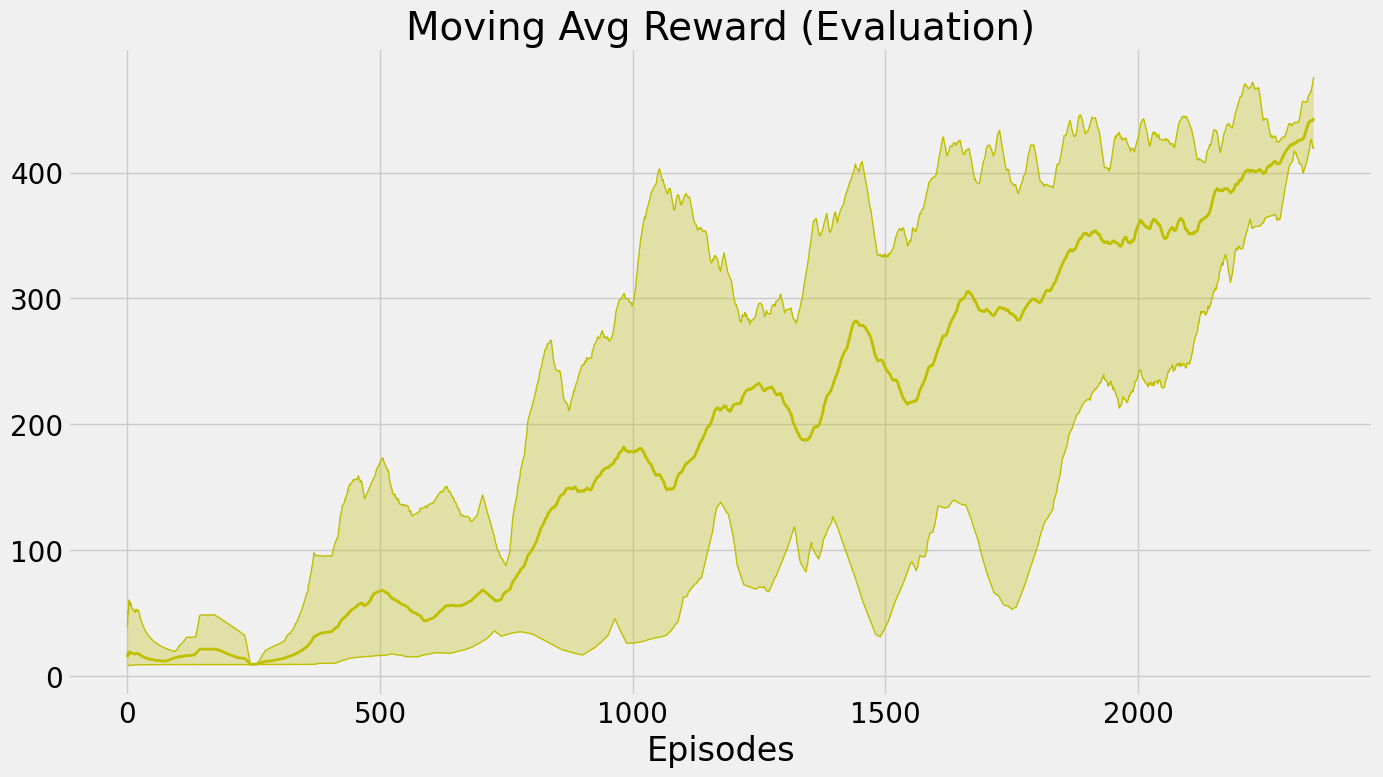

In [44]:
plt.plot(nfq_max_s, 'y', linewidth=1)
plt.plot(nfq_min_s, 'y', linewidth=1)
plt.plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
plt.fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)
plt.title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')

## Total Steps
The main issue with NFQ is that it takes too many steps to get decent performance. In other words, in terms of sample efficiency, NFQ does poorly. It needs many samples before it gets decent results. It doesn't get the most out of each sample.

Text(0.5, 0, 'Episodes')

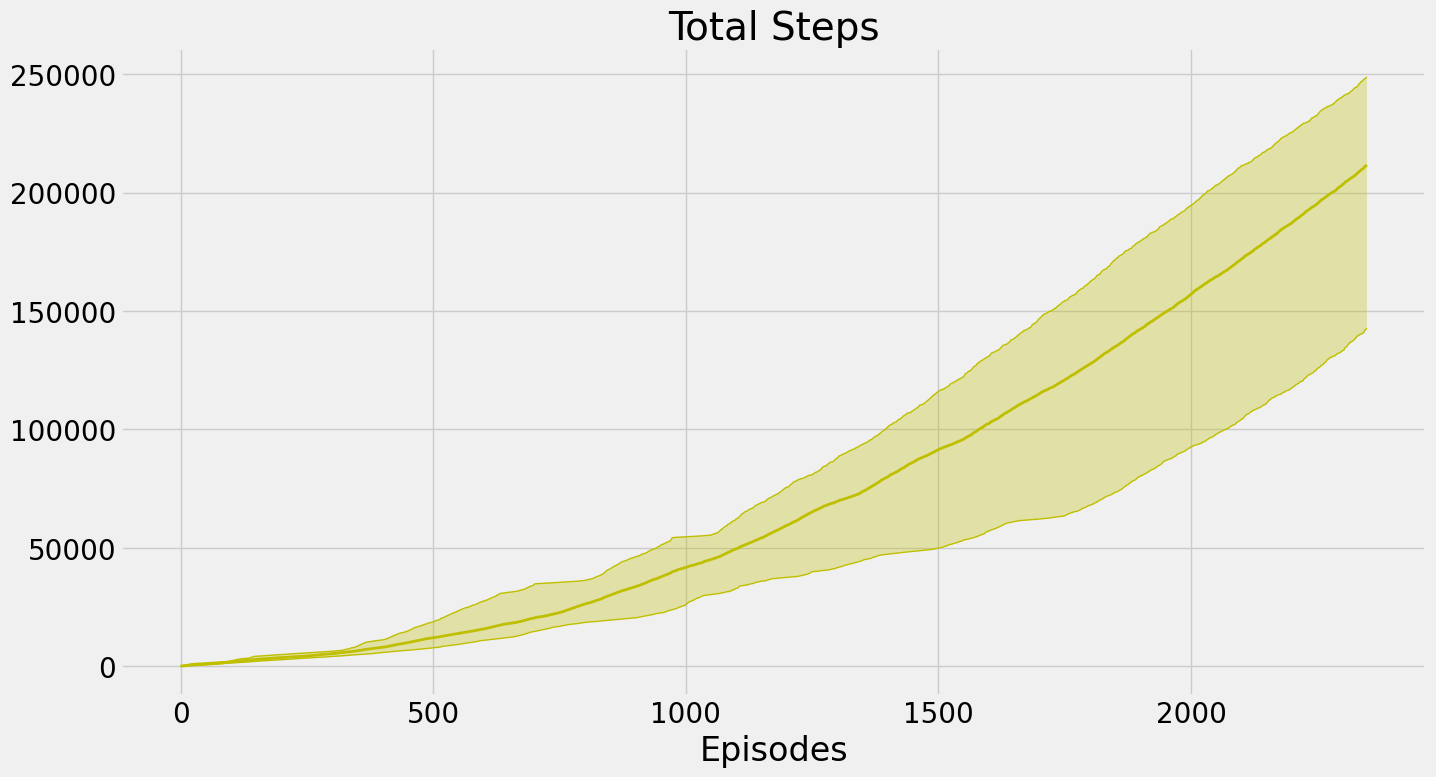

In [45]:
plt.plot(nfq_max_t, 'y', linewidth=1)
plt.plot(nfq_min_t, 'y', linewidth=1)
plt.plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
plt.fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)
plt.title('Total Steps')
plt.xlabel('Episodes')

## Training Time
Training time is the time excluding evaluation steps, statistics, etc.

Text(0.5, 0, 'Episodes')

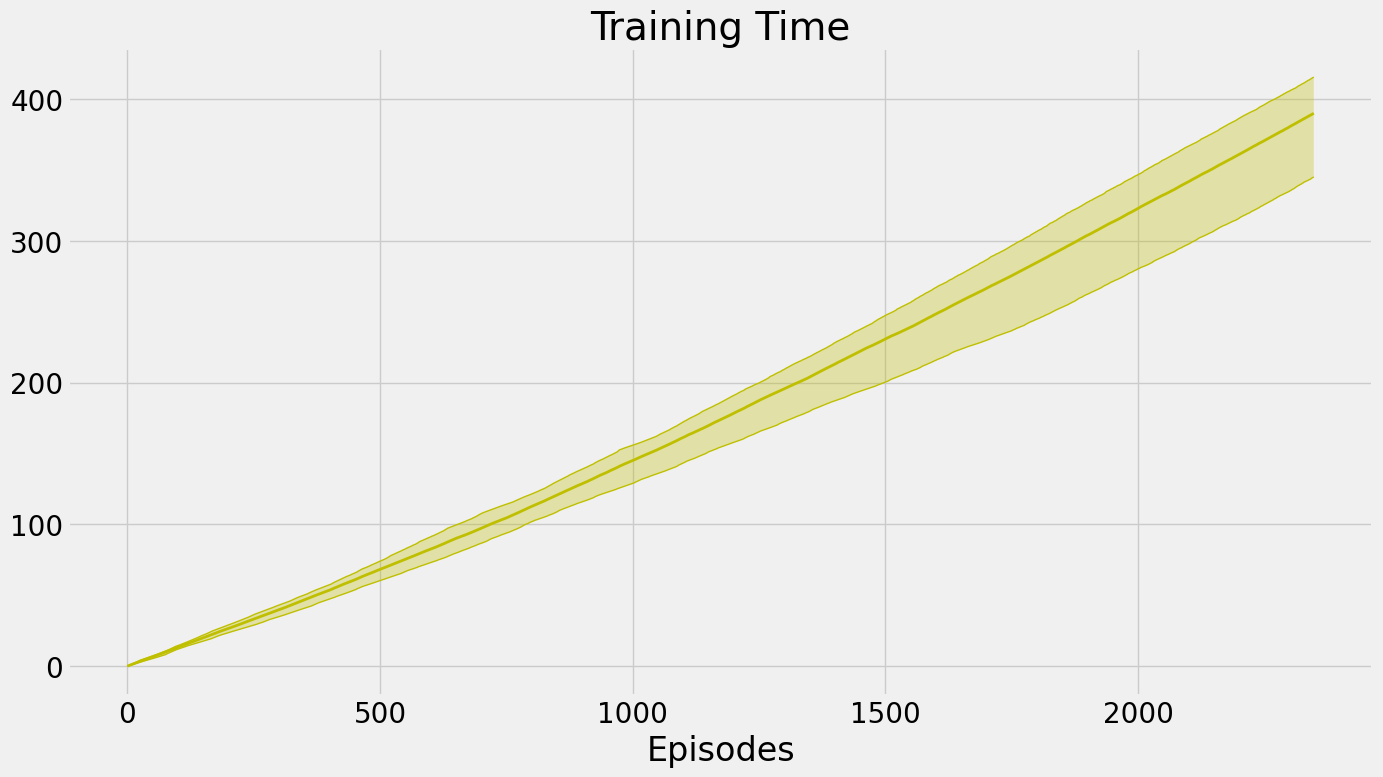

In [46]:
plt.plot(nfq_max_sec, 'y', linewidth=1)
plt.plot(nfq_min_sec, 'y', linewidth=1)
plt.plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
plt.fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)
plt.title('Training Time')
plt.xlabel('Episodes')

## Wall-clock Time
it shows how long it takes to run from beginning to end.

Text(0.5, 0, 'Episodes')

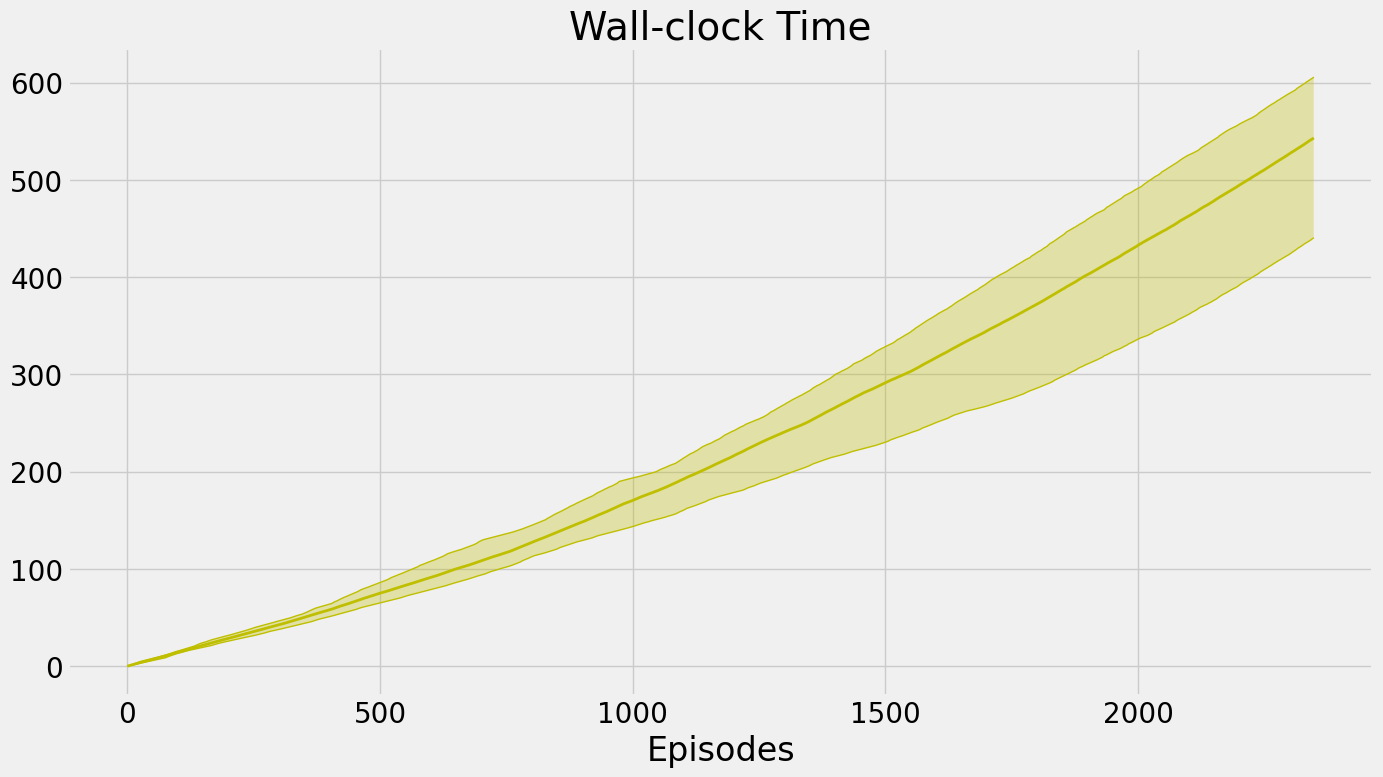

In [48]:
plt.plot(nfq_max_rt, 'y', linewidth=1)
plt.plot(nfq_min_rt, 'y', linewidth=1)
plt.plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
plt.fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)
plt.title('Wall-clock Time')
plt.xlabel('Episodes')

# DQN
NFQ addresses the IID and non-stationary target issues using batch. By growing a batch, we have the opportunity of optimising several samples at the same time. The larger the batch, the more opportunity for collecting a diverse set of experience samples. This somewhat addresses IID assumption.

NFQ addresses the stationarity of target requirements by using the same mini-batch in multiple sequential optimization steps - for every E episodes, we 'fit' the neuro-net to the same mini-batch K times. That K in there allows the optimsation method to move toward the target more stably. This is similar to supervised learning, where we gather a dataset and train for multiple epochs.

Deep Q-Network (DQN) addresses the above issues better, by using target network. Our targets are fixed for as many steps as we fix our target network. A target network is an previous instance of the neural network that we freeze for a number of steps. The gradient update has now time to catch up to the target, which is much more stable when froze. This adds stability to the updates. It is common to freeze these
target network weights for 10 to 10,000 steps at a time - e.g. 10 for simple problems like cart pole, 10000 for ATARI games.



## Replay buffer
In NFQ, we use mini-batch of 1024 samples, and train with it for 40 iterations, alternating between calculating new targets and optimising the network. These 1,024 samples are temporally correlated since most of them belong to the same trajectory since the maximum number of steps in a cart-pole episode is 500. One way to improve on this is to use a technique called experience replay.

Replay buffer / memory holds experience samples for several steps (much larger than 1024 steps - from 10k to 1M depending on the problem), allowing the sampling of mini-batches from a broad set of past experiences. it allows the agent to:
1. training process can use a more diverse mini-batch for udpates
2. the agent no longer has to fit the model to the same small mini-batch for multiple iterations.

Adequately sampling a sufficiently large replay buffer yields a slowmoving target, so the agent can now sample and train on every time step with a lower risk of divergence.

The downside of replay buffer is that it can hit a hardware memory limit quickly in high-dimensional env, e.g. image-based env like ATARI games where each state is represented with a stack of the 4 latest image frames.

Replay buffer gradient update: the only difference from NFQ is that we obtain the experiences used for training by sampling uniformly at random the replay buffer D, instead of using online experiences.
$$
∇_{θ_i} L_i(θ_i)=\mathbb{E}_{(s,a,r,s')\sim\mathcal U(\mathcal D)}\left[\left(r+γ\max_{a'}Q(s',a';θ^-)-Q(s,a;\theta_i)\right)\nabla_{θ_i}Q(s,a;\theta_i)\right]
$$
, where $θ^-$ is the frozen weights of the target neuro netwwork

This is the full gradient update for DQN - the one referred to as Nature DQN, which is DQN with a target network and a replay buffer.

In [21]:
class ReplayBuffer():
  def __init__(self, max_size=10000, batch_size=64):
    # states, actions, rewards, next states, done flags
    self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

    self.max_size = max_size
    self.batch_size = batch_size
    self._idx = 0 # current index of buffer
    self.size = 0

  def store(self, sample):
    s, a, r, p, d = sample
    self.ss_mem[self._idx] = s
    self.as_mem[self._idx] = a
    self.rs_mem[self._idx] = r
    self.ps_mem[self._idx] = p
    self.ds_mem[self._idx] = d

    self._idx += 1
    self._idx = self._idx % self.max_size

    self.size += 1
    self.size = min(self.size, self.max_size)

  def sample(self, batch_size=None):
    if batch_size == None:
      batch_size = self.batch_size

    # randomly choose 'batch_size' samples from buffer and put in experiences
    idxs = np.random.choice(self.size, batch_size, replace=False)
    experiences = np.vstack(self.ss_mem[idxs]), \
      np.vstack(self.as_mem[idxs]), \
      np.vstack(self.rs_mem[idxs]), \
      np.vstack(self.ps_mem[idxs]), \
      np.vstack(self.ds_mem[idxs])
    return experiences

  def __len__(self):
    return self.size


DQN has 3 main steps:
1. Collect experience: $(S_t, A_t, R_{t+1}, S_{t+1}, D_{t+1})$, and insert it into the replay buffer.
2. Randomly sample a mini-batch from the buffer and calculate the off-policy TD targets for the whole batch: $r + \gamma*max_{a’}Q(s’,a’; θ)$.
3. Fit the action-value function $Q(s,a; θ)$: Using MSE and RMSprop.

In [24]:
class DQN():
  def __init__(self,
               replay_buffer_fn,
               value_model_fn,
               value_optimizer_fn,
               value_optimizer_lr,
               training_strategy_fn,
               evaluation_strategy_fn,
               n_warmup_batches,
               update_target_every_steps):
    self.replay_buffer_fn = replay_buffer_fn
    self.value_model_fn = value_model_fn
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr
    self.training_strategy_fn = training_strategy_fn
    self.evaluation_strategy_fn = evaluation_strategy_fn
    self.n_warmup_batches = n_warmup_batches
    self.update_target_every_steps = update_target_every_steps

  # here we use the target_model for target, unlike NFQ which use online_model
  # the Q_sa still uses online_model
  def optimize_model(self, experiences):
    states, actions, rewards, next_states, is_terminals = experiences
    batch_size = len(is_terminals)

    # we get the values of Q-function at s_prime (next_state).
    # 'next_states' is plural because it's a batch of 'next_state'.
    # detach() here becasue we don't propagate values through this, this keeps
    # the predicted vlaue a constant since we only use it to calculate targets.
    # q_sa = self.online_model(next_states).detach()
    max_a_q_sp = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
    # *(1-is_terminals) to ensure terminal states are grounded to zero.
    target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)

    # get the current estimate of Q(s,a).
    q_sa = self.online_model(states).gather(1, actions)

    td_errors = target_q_sa - q_sa
    value_loss = td_errors.pow(2).mul(0.5).mean()
    # back prop
    self.value_optimizer.zero_grad()
    value_loss.backward()
    self.value_optimizer.step()

  def interaction_step(self, state, env):
    action = self.training_strategy.select_action(self.online_model, state)
    #print(f"interaction_step: online_model {self.online_model}, state {state}, action {action}")

    new_state, reward, is_terminal, info = env.step(action)
    # the cart-pole env has a wrapper that artificially teminates an episode after
    # some time steps. So we add extra code to check this.
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    is_failure = is_terminal and not is_truncated
    experience = (state, action, reward, new_state, float(is_failure))

    self.replay_buffer.store(experience) # the only difference from NFQ
    #self.experiences.append(experience)
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
    return new_state, is_terminal

  def update_network(self):
    for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
      # torch's copy_ copies tensor to another
      target.data.copy_(online.data)


  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):
    training_start, last_debug_time = time.time(), float('-inf')

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    nS, nA = env.observation_space.shape[0], env.action_space.n
    self.episode_timestep = []
    self.episode_reward = []
    self.episode_seconds = []
    self.evaluation_scores = []
    self.episode_exploration = []

    self.target_model = self.value_model_fn(nS, nA) # extra to NFQ
    self.online_model = self.value_model_fn(nS, nA)
    self.update_network() # extra to NFQ
    self.value_optimizer = self.value_optimizer_fn(self.online_model,
                                                   self.value_optimizer_lr)

    self.replay_buffer = self.replay_buffer_fn() # extra to NFQ
    self.training_strategy = training_strategy_fn()
    self.evaluation_strategy = evaluation_strategy_fn()
    # self.experiences = []

    # the 5 dim are: total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed
    result = np.empty((max_episodes, 5))
    result[:] = np.nan
    training_time = 0
    for episode in range(1, max_episodes+1):
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      self.episode_reward.append(0.0)
      self.episode_timestep.append(0.0)
      self.episode_exploration.append(0.0)

      for step in count(): # starting from 0
        state, is_terminal = self.interaction_step(state, env)
        # self.experiences is appended by self.interaction_step()

        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches # extra to NFQ
        if len(self.replay_buffer) > min_samples:
          experiences = self.replay_buffer.sample()
          experiences = self.online_model.load(experiences)
          self.optimize_model(experiences)

        if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
          self.update_network()

        # if len(self.experiences) >= self.batch_size:
        #   experiences = np.array(self.experiences, dtype=object)
        #   batches = [np.vstack(sars) for sars in experiences.T]
        #   experiences = self.online_model.load(batches)
        #   for _ in range(self.epochs):
        #     self.optimize_model(experiences)
        #   self.experiences.clear()

        if is_terminal:
          gc.collect()
          break

      # stats
      episode_elapsed = time.time() - episode_start
      self.episode_seconds.append(episode_elapsed)
      training_time += episode_elapsed
      evaluation_score, _ = self.evaluate(self.online_model, env)
      self.save_checkpoint(episode-1, self.online_model)

      total_step = int(np.sum(self.episode_timestep))
      self.evaluation_scores.append(evaluation_score)

      mean_10_reward = np.mean(self.episode_reward[-10:])
      std_10_reward = np.std(self.episode_reward[-10:])

      mean_100_reward = np.mean(self.episode_reward[-100:])
      std_100_reward = np.std(self.episode_reward[-100:])

      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      std_100_eval_score = np.std(self.evaluation_scores[-100:])

      lst_100_exp_rat = np.array(self.episode_exploration[-100:]) \
        / np.array(self.episode_timestep[-100:])
      mean_100_exp_rat = np.mean(lst_100_exp_rat)
      std_100_exp_rat = np.std(lst_100_exp_rat)

      wallclock_elapsed = time.time() - training_start
      result[episode-1] = total_step, mean_100_reward, \
        mean_100_eval_score, training_time, wallclock_elapsed

      reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
      reached_max_minutes = wallclock_elapsed >= max_minutes * 60
      reached_max_episodes = episode >= max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
      training_is_over = reached_max_minutes or reached_max_episodes \
        or reached_goal_mean_reward

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      print(debug_message, end='\r', flush=True)
      if reached_debug_time or training_is_over:
        print(ERASE_LINE + debug_message, flush=True)
        last_debug_time = time.time()
      if training_is_over: # print crosses and ticks
        if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
        if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
        if reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')
        break # break out of for step in count() loop

    final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
    wallclock_time = time.time() - training_start
    print('Training complete.')
    print(f'Final evaluation score {final_eval_score:.2f}\u00B1{score_std:.2f}'\
          ' in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.\n')
    env.close(); del env
    self.get_cleaned_checkpoints()
    return result, final_eval_score, training_time, wallclock_time

  # same as NFQ
  def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        a = self.evaluation_strategy.select_action(eval_policy_model, s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  # same as NFQ
  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int16)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix


    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.online_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.online_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_videos_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.online_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.online_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_videos_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        #subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))

## Train DQN

In [25]:
dqn_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
      'env_name': 'CartPole-v1',
      'gamma': 1.00,
      'max_minutes': 20,
      'max_episodes': 10000,
      'goal_mean_100_reward': 475
  }

  value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512, 128))
  value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
  value_optimizer_lr = 5e-4

  # training_strategy_fn = lambda: EGreedyStrategy(epsilon=0.5)
  # training_strategy_fn = lambda: EGreedyLinearStrategy(init_epsilon=1.0,
  #                                                      min_epsilon=0.3,
  #                                                      max_steps=20000)
  # training_strategy_fn = lambda: SoftMaxStrategy(init_temp=1.0,
  #                                                min_temp=0.1,
  #                                                exploration_ratio=0.8,
  #                                                max_steps=20000)
  training_strategy_fn = lambda: EGreedyExpStrategy(init_epsilon=1.0,
                                                    min_epsilon=0.3,
                                                    decay_steps=20000)
  evaluation_strategy_fn = lambda: GreedyStrategy()

  replay_buffer_fn = lambda: ReplayBuffer(max_size=50000, batch_size=64)
  n_warmup_batches = 5
  update_target_every_steps = 10

  env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = DQN(replay_buffer_fn,
              value_model_fn,
              value_optimizer_fn,
              value_optimizer_lr,
              training_strategy_fn,
              evaluation_strategy_fn,
              n_warmup_batches,
              update_target_every_steps)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallcock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward
  )
  dqn_results.append(result)
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent

dqn_results = np.array(dqn_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000017, ar 10 017.0±000.0, 100 017.0±000.0, ex 100 0.4±0.0, ev 019.0±000.0


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


el 00:01:01, ep 0122, ts 008497, ar 10 199.1±090.7, 100 079.8±079.2, ex 100 0.4±0.1, ev 204.7±116.7
el 00:02:01, ep 0157, ts 018427, ar 10 313.8±108.7, 100 169.0±125.7, ex 100 0.3±0.1, ev 295.0±107.6
el 00:03:02, ep 0186, ts 028405, ar 10 398.7±099.4, 100 250.6±128.5, ex 100 0.2±0.1, ev 358.8±113.6
el 00:04:05, ep 0209, ts 038679, ar 10 443.7±112.8, 100 326.1±127.9, ex 100 0.2±0.0, ev 409.2±110.2
el 00:05:07, ep 0233, ts 048525, ar 10 387.1±142.3, 100 371.9±124.0, ex 100 0.2±0.0, ev 459.3±080.4
el 00:05:42, ep 0244, ts 054012, ar 10 498.7±003.9, 100 397.4±119.1, ex 100 0.2±0.0, ev 475.1±066.3
--> reach_goal_mean_reward ✓
Training complete.
Final evaluation score 489.79±21.63 in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.

el 00:00:00, ep 0000, ts 000029, ar 10 029.0±000.0, 100 029.0±000.0, ex 100 0.6±0.0, ev 010.0±000.0
el 00:01:00, ep 0137, ts 007963, ar 10 179.4±061.4, 100 071.1±068.9, ex 100 0.4±0.1, ev 278.3±113.7
el 00:02:00, ep 0179, ts 018354, ar 10

In [26]:
best_agent.demo_progression()

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specif

[('./video_prog/rl-video-episode-0.mp4', './video_prog/rl-video-episode-0.meta.json'), ('./video_prog/rl-video-episode-1.mp4', './video_prog/rl-video-episode-1.meta.json')]


In [27]:
best_agent.demo_last()

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecate

[('./video_last/rl-video-episode-0.mp4', './video_last/rl-video-episode-0.meta.json'), ('./video_last/rl-video-episode-1.mp4', './video_last/rl-video-episode-1.meta.json')]


In [28]:
dqn_max_t, dqn_max_r, dqn_max_s, \
    dqn_max_sec, dqn_max_rt = np.max(dqn_results, axis=0).T
dqn_min_t, dqn_min_r, dqn_min_s, \
    dqn_min_sec, dqn_min_rt = np.min(dqn_results, axis=0).T
dqn_mean_t, dqn_mean_r, dqn_mean_s, \
    dqn_mean_sec, dqn_mean_rt = np.mean(dqn_results, axis=0).T
dqn_x = np.arange(np.max((len(dqn_mean_s), len(nfq_mean_s))))

In [29]:
dqn_root_dir = os.path.join(RESULTS_DIR, 'dqn')
not os.path.exists(dqn_root_dir) and os.makedirs(dqn_root_dir)

np.save(os.path.join(dqn_root_dir, 'x'), dqn_x)

np.save(os.path.join(dqn_root_dir, 'max_r'), dqn_max_r)
np.save(os.path.join(dqn_root_dir, 'min_r'), dqn_min_r)
np.save(os.path.join(dqn_root_dir, 'mean_r'), dqn_mean_r)

np.save(os.path.join(dqn_root_dir, 'max_s'), dqn_max_s)
np.save(os.path.join(dqn_root_dir, 'min_s'), dqn_min_s )
np.save(os.path.join(dqn_root_dir, 'mean_s'), dqn_mean_s)

np.save(os.path.join(dqn_root_dir, 'max_t'), dqn_max_t)
np.save(os.path.join(dqn_root_dir, 'min_t'), dqn_min_t)
np.save(os.path.join(dqn_root_dir, 'mean_t'), dqn_mean_t)

np.save(os.path.join(dqn_root_dir, 'max_sec'), dqn_max_sec)
np.save(os.path.join(dqn_root_dir, 'min_sec'), dqn_min_sec)
np.save(os.path.join(dqn_root_dir, 'mean_sec'), dqn_mean_sec)

np.save(os.path.join(dqn_root_dir, 'max_rt'), dqn_max_rt)
np.save(os.path.join(dqn_root_dir, 'min_rt'), dqn_min_rt)
np.save(os.path.join(dqn_root_dir, 'mean_rt'), dqn_mean_rt)

## loading from files

In [36]:
!rm -f results/dqn/*
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/max_r.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/max_rt.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/max_s.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/max_sec.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/max_t.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/mean_r.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/mean_rt.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/mean_s.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/mean_sec.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/mean_t.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/min_r.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/min_rt.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/min_s.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/min_sec.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/min_t.npy
!wget -nv -P results/dqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/x.npy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2024-12-26 22:47:30 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/max_r.npy [80128/80128] -> "results/dqn/max_r.npy" [1]
2024-12-26 22:47:30 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/max_rt.npy [80128/80128] -> "results/dqn/max_rt.npy" [1]
2024-12-26 22:47:30 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/max_s.npy [80128/80128] -> "results/dqn/max_s.npy" [1]
2024-12-26 22:47:30 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/max_sec.npy [80128/80128] -> "results/dqn/max_sec.npy" [1]
2024-12-26 22:47:31 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/max_t.npy [80128/80128] -> "results/dqn/max_t.npy" [1]
2024-12-26 22:47:31 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/dqn/mean_r.npy [80128/80128] -> "results/dqn/mean_r.npy" [1]
2024-12-26 22:47:31 URL:https://raw.githubusercontent.com/rome

In [47]:
dqn_root_dir = os.path.join(RESULTS_DIR, 'dqn')

dqn_x = np.load(os.path.join(dqn_root_dir, 'x.npy'))

dqn_max_r = np.load(os.path.join(dqn_root_dir, 'max_r.npy'))
dqn_min_r = np.load(os.path.join(dqn_root_dir, 'min_r.npy'))
dqn_mean_r = np.load(os.path.join(dqn_root_dir, 'mean_r.npy'))

dqn_max_s = np.load(os.path.join(dqn_root_dir, 'max_s.npy'))
dqn_min_s = np.load(os.path.join(dqn_root_dir, 'min_s.npy'))
dqn_mean_s = np.load(os.path.join(dqn_root_dir, 'mean_s.npy'))

dqn_max_t = np.load(os.path.join(dqn_root_dir, 'max_t.npy'))
dqn_min_t = np.load(os.path.join(dqn_root_dir, 'min_t.npy'))
dqn_mean_t = np.load(os.path.join(dqn_root_dir, 'mean_t.npy'))

dqn_max_sec = np.load(os.path.join(dqn_root_dir, 'max_sec.npy'))
dqn_min_sec = np.load(os.path.join(dqn_root_dir, 'min_sec.npy'))
dqn_mean_sec = np.load(os.path.join(dqn_root_dir, 'mean_sec.npy'))

dqn_max_rt = np.load(os.path.join(dqn_root_dir, 'max_rt.npy'))
dqn_min_rt = np.load(os.path.join(dqn_root_dir, 'min_rt.npy'))
dqn_mean_rt = np.load(os.path.join(dqn_root_dir, 'mean_rt.npy'))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## plotting DQN

It's obvious that DQN is more sample efficient and less noisy than NFQ.

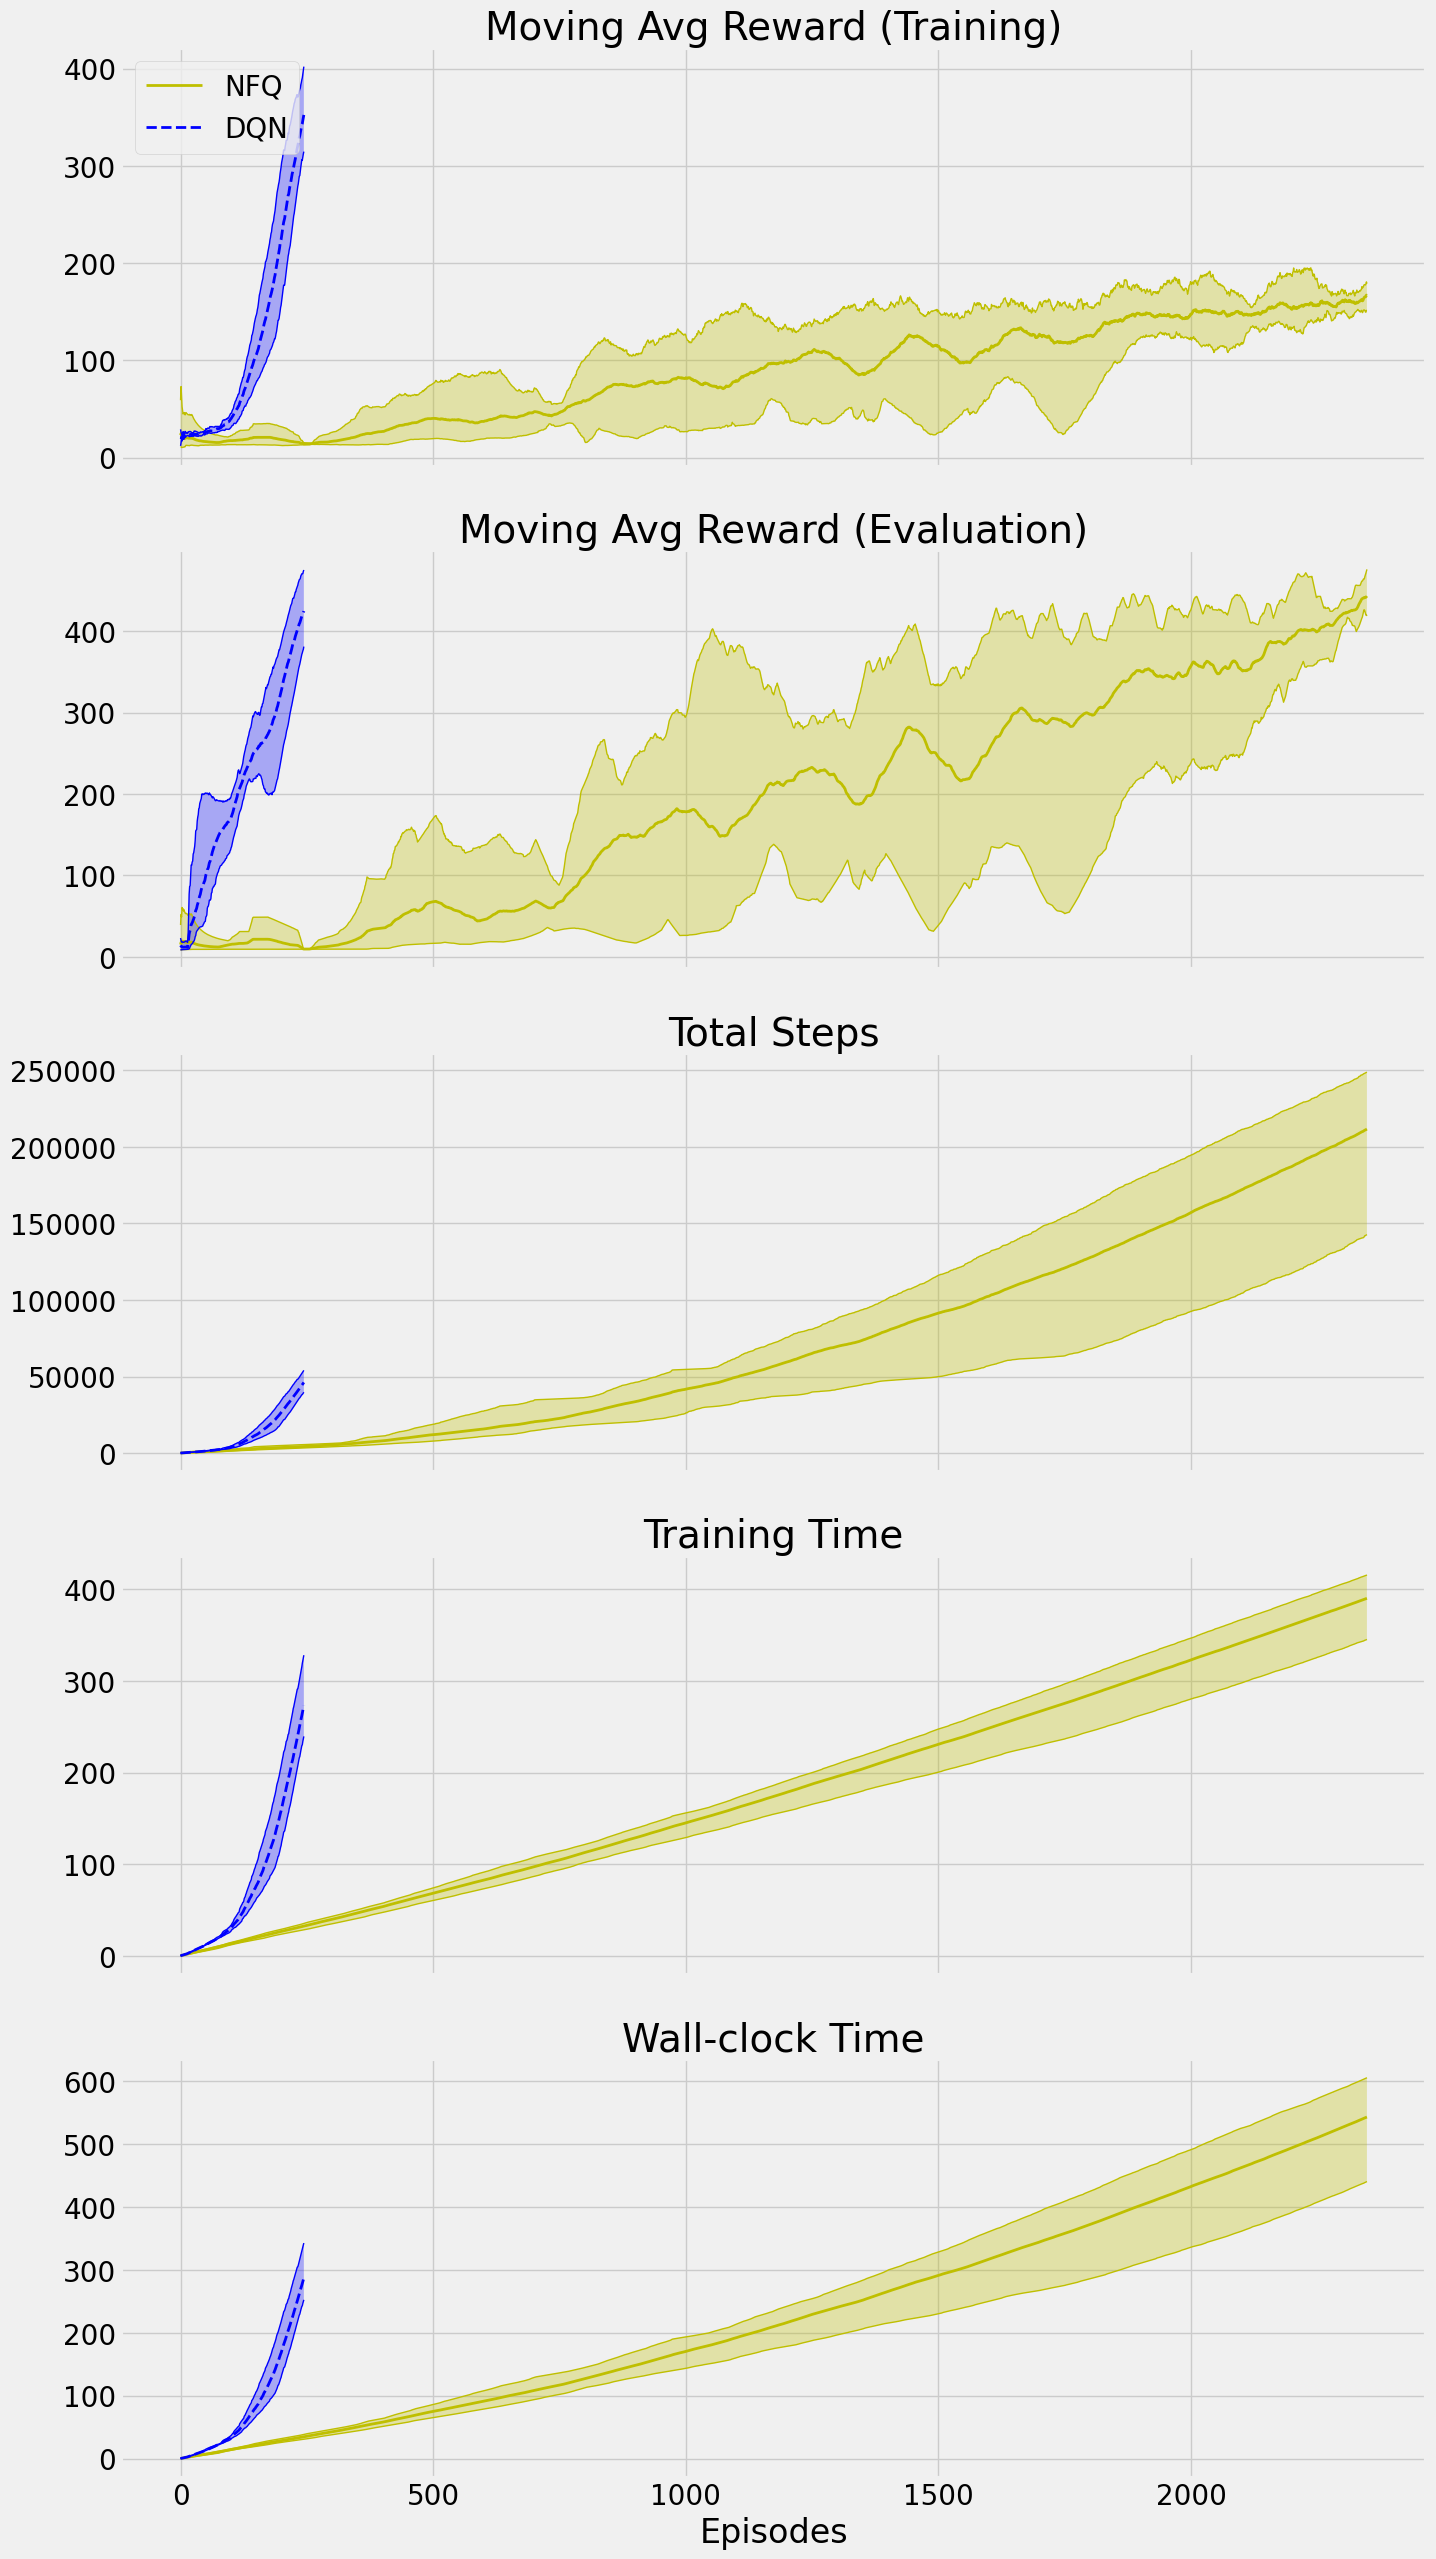

In [48]:
fig, axs = plt.subplots(5, 1, figsize=(15,30), sharey=False, sharex=True)

# NFQ
axs[0].plot(nfq_max_r, 'y', linewidth=1)
axs[0].plot(nfq_min_r, 'y', linewidth=1)
axs[0].plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
axs[0].fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)

axs[1].plot(nfq_max_s, 'y', linewidth=1)
axs[1].plot(nfq_min_s, 'y', linewidth=1)
axs[1].plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
axs[1].fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)

axs[2].plot(nfq_max_t, 'y', linewidth=1)
axs[2].plot(nfq_min_t, 'y', linewidth=1)
axs[2].plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
axs[2].fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)

axs[3].plot(nfq_max_sec, 'y', linewidth=1)
axs[3].plot(nfq_min_sec, 'y', linewidth=1)
axs[3].plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
axs[3].fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(nfq_max_rt, 'y', linewidth=1)
axs[4].plot(nfq_min_rt, 'y', linewidth=1)
axs[4].plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
axs[4].fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)

# DQN
axs[0].plot(dqn_max_r, 'b', linewidth=1)
axs[0].plot(dqn_min_r, 'b', linewidth=1)
axs[0].plot(dqn_mean_r, 'b--', label='DQN', linewidth=2)
axs[0].fill_between(dqn_x, dqn_min_r, dqn_max_r, facecolor='b', alpha=0.3)

axs[1].plot(dqn_max_s, 'b', linewidth=1)
axs[1].plot(dqn_min_s, 'b', linewidth=1)
axs[1].plot(dqn_mean_s, 'b--', label='DQN', linewidth=2)
axs[1].fill_between(dqn_x, dqn_min_s, dqn_max_s, facecolor='b', alpha=0.3)

axs[2].plot(dqn_max_t, 'b', linewidth=1)
axs[2].plot(dqn_min_t, 'b', linewidth=1)
axs[2].plot(dqn_mean_t, 'b--', label='DQN', linewidth=2)
axs[2].fill_between(dqn_x, dqn_min_t, dqn_max_t, facecolor='b', alpha=0.3)

axs[3].plot(dqn_max_sec, 'b', linewidth=1)
axs[3].plot(dqn_min_sec, 'b', linewidth=1)
axs[3].plot(dqn_mean_sec, 'b--', label='DQN', linewidth=2)
axs[3].fill_between(dqn_x, dqn_min_sec, dqn_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(dqn_max_rt, 'b', linewidth=1)
axs[4].plot(dqn_min_rt, 'b', linewidth=1)
axs[4].plot(dqn_mean_rt, 'b--', label='DQN', linewidth=2)
axs[4].fill_between(dqn_x, dqn_min_rt, dqn_max_rt, facecolor='b', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# Double DQN (DDQN)

Improvement to DQN by adding Double learnign to DQN agent, yielding consistantly better performance.

Q-learning tends to overestimate action-value functions, so does DQN. We use the same off-policy TD target with max operator. The estimated values are often off-center (either higher or lower than true values). So taking the max of that has a positive bias, and performance suffers.

## Loss function
choose a more forgiving loss function.

In [54]:
pred = np.linspace(-100,100,500)
truth = np.zeros(pred.shape)
error = truth - pred

In [57]:
se = 0.5*error**2   # squared error
ae = np.abs(error)  # absolute error
# huber error
he = lambda delta=1: ae - delta/2 if delta == 0 else \
              np.where(ae <= np.repeat(delta, len(ae)), se, delta*(ae - delta/2))

In [58]:
print(np.mean(se))
print(torch.Tensor(error).pow(2).mul(0.5).mean())

1673.3466933867735
tensor(1673.3467)


In [59]:
print(np.mean(ae))
print(torch.Tensor(error).abs().mean())

50.1002004008016
tensor(50.1002)


In [60]:
print(np.mean(he(float('inf'))))
print(np.mean(he(0)))

1673.3466933867735
50.1002004008016


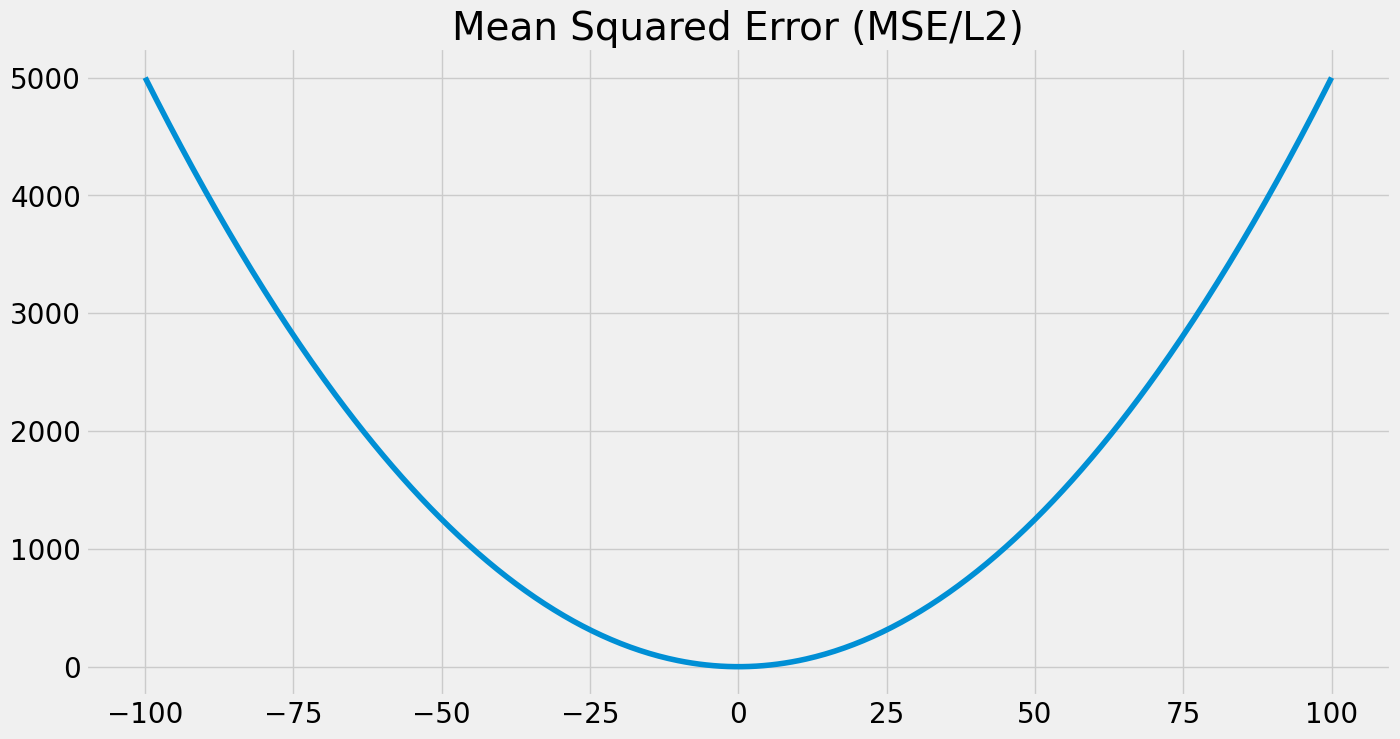

In [61]:
plt.plot(pred, se)
plt.title('Mean Squared Error (MSE/L2)')
plt.show()

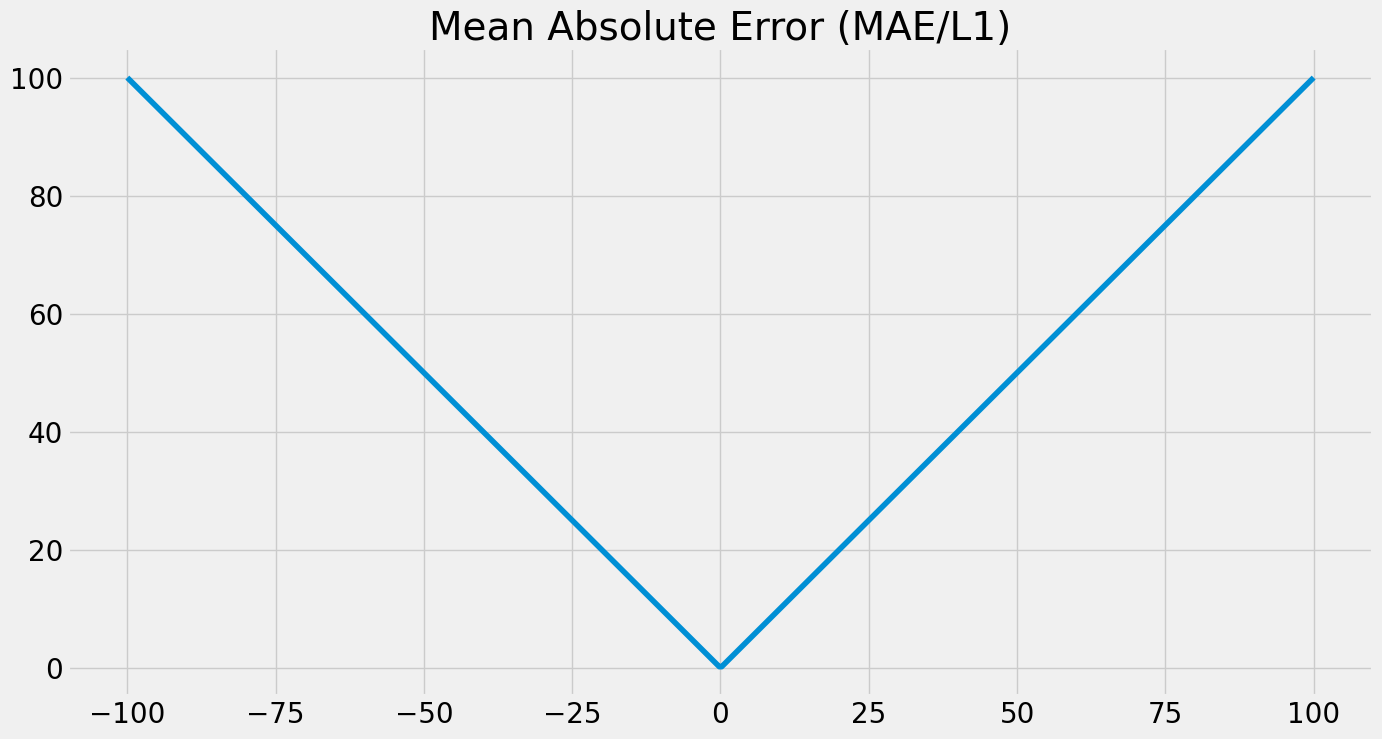

In [62]:
plt.plot(pred, ae)
plt.title('Mean Absolute Error (MAE/L1)')
plt.show()

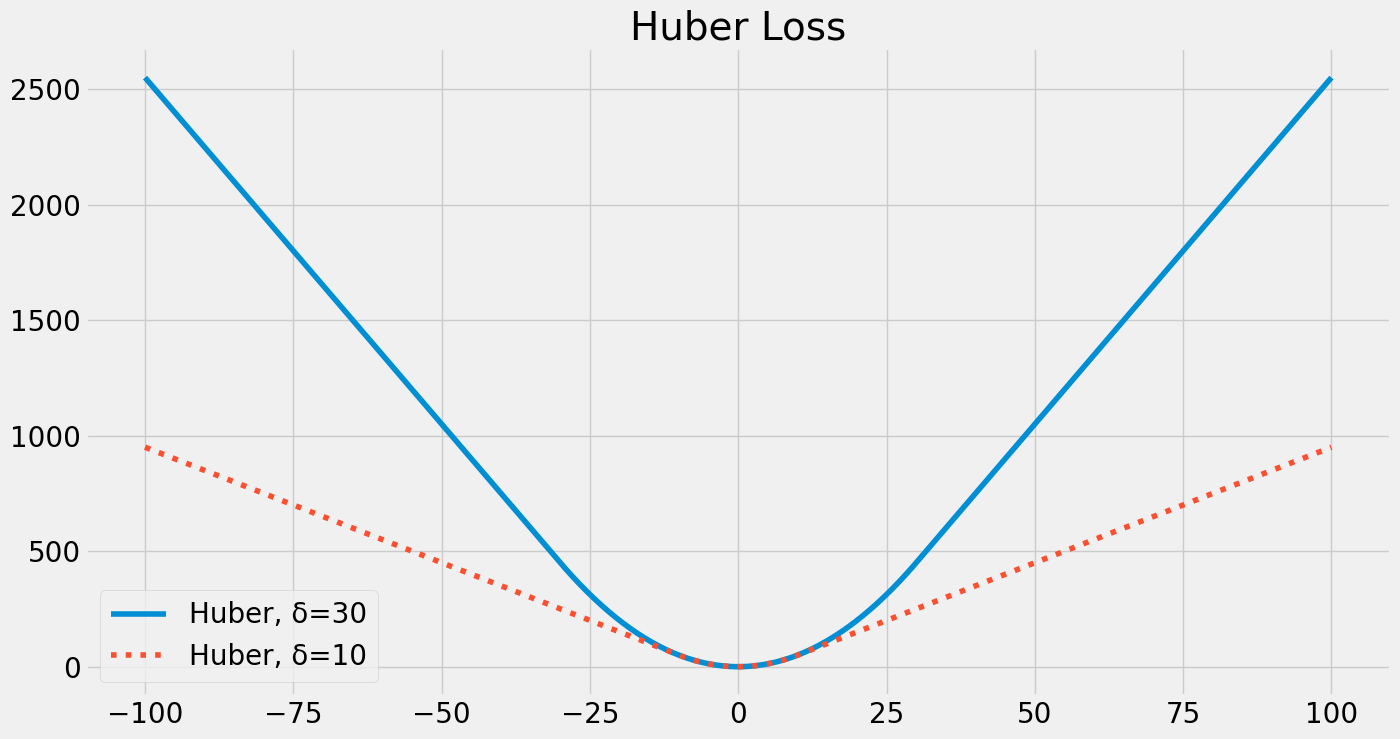

In [63]:
plot1, = plt.plot(pred, he(30))
plot2, = plt.plot(pred, he(10), ':')
plt.title('Huber Loss')
plt.legend([plot1,plot2],["Huber, δ=30", "Huber, δ=10"])
plt.show()

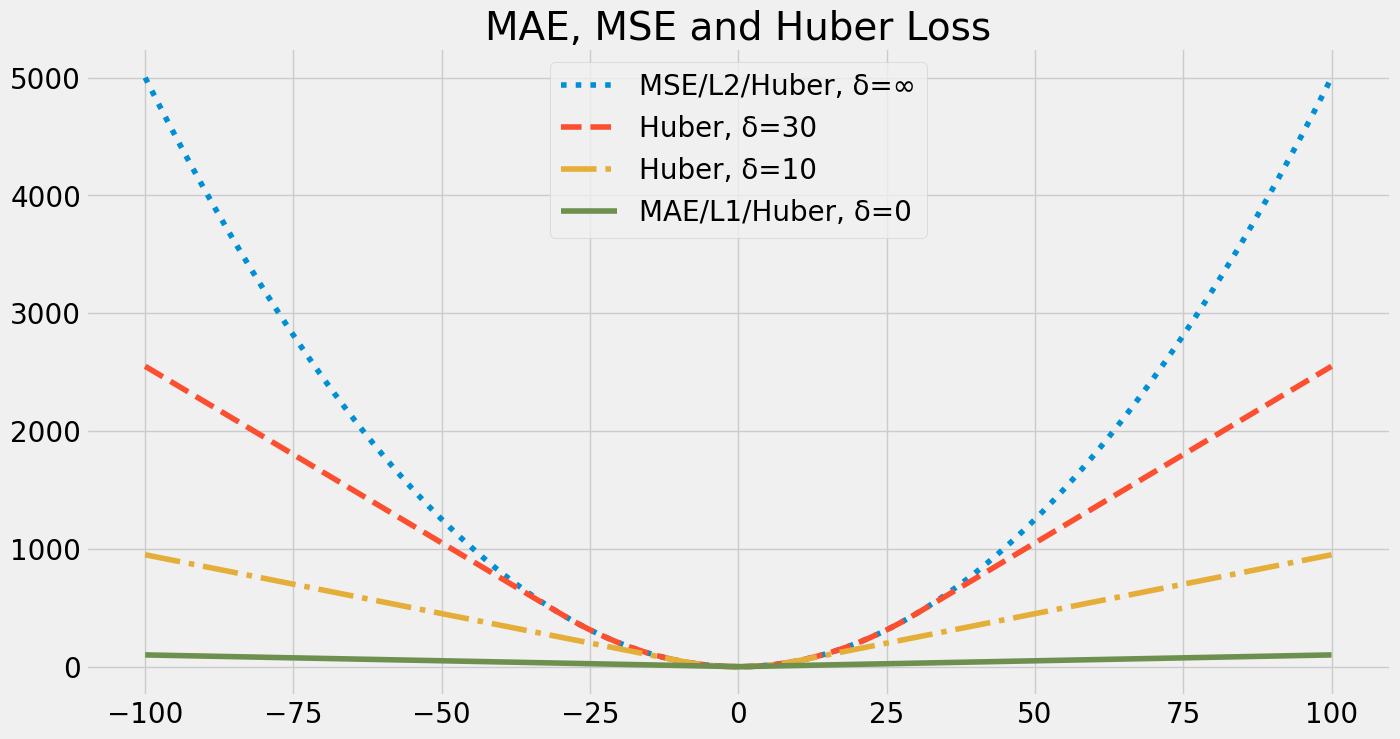

In [64]:
plot1, = plt.plot(pred, he(float('inf')), ':')
plot2, = plt.plot(pred, he(30), '--')
plot3, = plt.plot(pred, he(10), '-.')
plot4, = plt.plot(pred, he(0))
# plot4, = plt.plot(pred, ae)
plt.title('MAE, MSE and Huber Loss')
plt.legend([plot1,plot2,plot3,plot4],["MSE/L2/Huber, δ=∞", "Huber, δ=30", "Huber, δ=10", "MAE/L1/Huber, δ=0"])
plt.show()

## separating action selection and action evaluation

The *max* of Q-function is the same as the Q-function of the *argmax* action. $\max_{a'}Q(s',a';θ^-)$ is equivalent to $Q(s', \arg\max_{a'}Q(s',a';θ^-);θ^-)$

Substituting the above into:
$$
∇_{θ_i} L_i(θ_i)=\mathbb{E}_{(s,a,r,s')\sim\mathcal U(\mathcal D)}\left[\left(r+γ\max_{a'}Q(s',a';θ_i)-Q(s,a;\theta^-)\right)\nabla_{θ_i}Q(s,a;\theta_i)\right]
$$
we get:
$$
∇_{θ_i} L_i(θ_i)=\mathbb{E}_{(s,a,r,s')\sim\mathcal U(\mathcal D)}\left[\left(r+γQ(s', \arg\max_{a'}Q(s',a';θ^-);θ^-)-Q(s,a;\theta_i)\right)\nabla_{θ_i}Q(s,a;\theta_i)\right]
$$

In [71]:
class DDQN():
  def __init__(self,
               replay_buffer_fn,
               value_model_fn,
               value_optimizer_fn,
               value_optimizer_lr,
               max_gradient_norm, # extra to DQN
               training_strategy_fn,
               evaluation_strategy_fn,
               n_warmup_batches,
               update_target_every_steps):
    self.replay_buffer_fn = replay_buffer_fn
    self.value_model_fn = value_model_fn
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr
    self.max_gradient_norm = max_gradient_norm
    self.training_strategy_fn = training_strategy_fn
    self.evaluation_strategy_fn = evaluation_strategy_fn
    self.n_warmup_batches = n_warmup_batches
    self.update_target_every_steps = update_target_every_steps

  def optimize_model(self, experiences):
    states, actions, rewards, next_states, is_terminals = experiences
    batch_size = len(is_terminals)

    # we use Q or argmax, instead of max of Q comparing to DQN
    # also, argmax using online_model, q_sp using target_model
    argmax_a_q_sp = self.online_model(next_states).max(1)[1]
    q_sp = self.target_model(next_states).detach()
    max_a_q_sp = q_sp[np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)

    # max_a_q_sp = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
    # *(1-is_terminals) to ensure terminal states are grounded to zero.
    target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)

    # get the current estimate of Q(s,a).
    q_sa = self.online_model(states).gather(1, actions)

    td_errors = target_q_sa - q_sa
    value_loss = td_errors.pow(2).mul(0.5).mean()
    # back prop
    self.value_optimizer.zero_grad()
    value_loss.backward()
    # clip gradients during training of NN, to prevent exploding gradient prob.
    torch.nn.utils.clip_grad_norm_(self.online_model.parameters(),
                                   self.max_gradient_norm)
    self.value_optimizer.step()

  # same as DQN
  def interaction_step(self, state, env):
    action = self.training_strategy.select_action(self.online_model, state)

    new_state, reward, is_terminal, info = env.step(action)
    # the cart-pole env has a wrapper that artificially teminates an episode after
    # some time steps. So we add extra code to check this.
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    is_failure = is_terminal and not is_truncated
    experience = (state, action, reward, new_state, float(is_failure))

    self.replay_buffer.store(experience)
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
    return new_state, is_terminal

  # same as DQN
  def update_network(self):
    for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
      # torch's copy_ copies tensor to another
      target.data.copy_(online.data)

  # same as DQN
  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):
    training_start, last_debug_time = time.time(), float('-inf')

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    nS, nA = env.observation_space.shape[0], env.action_space.n
    self.episode_timestep = []
    self.episode_reward = []
    self.episode_seconds = []
    self.evaluation_scores = []
    self.episode_exploration = []

    self.target_model = self.value_model_fn(nS, nA)
    self.online_model = self.value_model_fn(nS, nA)
    self.update_network()
    self.value_optimizer = self.value_optimizer_fn(self.online_model,
                                                   self.value_optimizer_lr)

    self.replay_buffer = self.replay_buffer_fn()
    self.training_strategy = training_strategy_fn()
    self.evaluation_strategy = evaluation_strategy_fn()

    # the 5 dim are: total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed
    result = np.empty((max_episodes, 5))
    result[:] = np.nan
    training_time = 0
    for episode in range(1, max_episodes+1):
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      self.episode_reward.append(0.0)
      self.episode_timestep.append(0.0)
      self.episode_exploration.append(0.0)

      for step in count(): # starting from 0
        state, is_terminal = self.interaction_step(state, env)
        # self.experiences is appended by self.interaction_step()

        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        if len(self.replay_buffer) > min_samples:
          experiences = self.replay_buffer.sample()
          experiences = self.online_model.load(experiences)
          self.optimize_model(experiences)

        if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
          self.update_network()

        if is_terminal:
          gc.collect()
          break

      # stats
      episode_elapsed = time.time() - episode_start
      self.episode_seconds.append(episode_elapsed)
      training_time += episode_elapsed
      evaluation_score, _ = self.evaluate(self.online_model, env)
      self.save_checkpoint(episode-1, self.online_model)

      total_step = int(np.sum(self.episode_timestep))
      self.evaluation_scores.append(evaluation_score)

      mean_10_reward = np.mean(self.episode_reward[-10:])
      std_10_reward = np.std(self.episode_reward[-10:])

      mean_100_reward = np.mean(self.episode_reward[-100:])
      std_100_reward = np.std(self.episode_reward[-100:])

      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      std_100_eval_score = np.std(self.evaluation_scores[-100:])

      lst_100_exp_rat = np.array(self.episode_exploration[-100:]) \
        / np.array(self.episode_timestep[-100:])
      mean_100_exp_rat = np.mean(lst_100_exp_rat)
      std_100_exp_rat = np.std(lst_100_exp_rat)

      wallclock_elapsed = time.time() - training_start
      result[episode-1] = total_step, mean_100_reward, \
        mean_100_eval_score, training_time, wallclock_elapsed

      reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
      reached_max_minutes = wallclock_elapsed >= max_minutes * 60
      reached_max_episodes = episode >= max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
      training_is_over = reached_max_minutes or reached_max_episodes \
        or reached_goal_mean_reward

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      print(debug_message, end='\r', flush=True)
      if reached_debug_time or training_is_over:
        print(ERASE_LINE + debug_message, flush=True)
        last_debug_time = time.time()
      if training_is_over: # print crosses and ticks
        if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
        if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
        if reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')
        break # break out of for step in count() loop

    final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
    wallclock_time = time.time() - training_start
    print('Training complete.')
    print(f'Final evaluation score {final_eval_score:.2f}\u00B1{score_std:.2f}'\
          ' in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.\n')
    env.close(); del env
    self.get_cleaned_checkpoints()
    return result, final_eval_score, training_time, wallclock_time

  # same as NFQ, DQN
  def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        a = self.evaluation_strategy.select_action(eval_policy_model, s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  # same as NFQ, DQN
  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int16)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix


    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.online_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.online_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.online_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.online_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))

## Train DDQN

In [ ]:
ddqn_results = []
ddqn_agents, best_ddqn_agent_key, best_eval_score = {}, None, float('-inf')
for seed in SEEDS:
  environment_settings = {
      'env_name': 'CartPole-v1',
      'gamma': 1.00,
      'max_minutes': 20,
      'max_episodes': 10000,
      'goal_mean_100_reward': 475
  }

  value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512, 128))
  value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
  value_optimizer_lr = 5e-4
  max_gradient_norm = float('inf')

  # training_strategy_fn = lambda: EGreedyStrategy(epsilon=0.5)
  # training_strategy_fn = lambda: EGreedyLinearStrategy(init_epsilon=1.0,
  #                                                      min_epsilon=0.3,
  #                                                      max_steps=20000)
  # training_strategy_fn = lambda: SoftMaxStrategy(init_temp=1.0,
  #                                                min_temp=0.1,
  #                                                exploration_ratio=0.8,
  #                                                max_steps=20000)
  training_strategy_fn = lambda: EGreedyExpStrategy(init_epsilon=1.0,
                                                    min_epsilon=0.3,
                                                    decay_steps=20000)
  evaluation_strategy_fn = lambda: GreedyStrategy()

  replay_buffer_fn = lambda: ReplayBuffer(max_size=50000, batch_size=64)
  n_warmup_batches = 5
  update_target_every_steps = 10

  env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = DDQN(replay_buffer_fn,
              value_model_fn,
              value_optimizer_fn,
              value_optimizer_lr,
              max_gradient_norm,
              training_strategy_fn,
              evaluation_strategy_fn,
              n_warmup_batches,
              update_target_every_steps)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallcock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward
  )
  ddqn_results.append(result)
  ddqn_agents[seed] = agent # extra to DQN
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_ddqn_agent_key = seed # diff than DQN

ddqn_results = np.array(ddqn_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000017, ar 10 017.0±000.0, 100 017.0±000.0, ex 100 0.4±0.0, ev 019.0±000.0
el 00:01:00, ep 0107, ts 004516, ar 10 090.3±056.3, 100 043.3±037.7, ex 100 0.4±0.1, ev 143.6±101.5
el 00:02:00, ep 0144, ts 011223, ar 10 175.0±089.9, 100 100.8±090.5, ex 100 0.3±0.1, ev 225.4±110.5
el 00:03:04, ep 0173, ts 018317, ar 10 293.4±086.1, 100 160.2±110.1, ex 100 0.3±0.1, ev 287.2±101.4
el 00:04:10, ep 0189, ts 023482, ar 10 319.8±127.0, 100 202.6±119.8, ex 100 0.2±0.1, ev 325.6±102.5


In [ ]:
ddqn_agents[best_ddqn_agent_key].demo_progression()

In [ ]:
ddqn_agents[best_ddqn_agent_key].demo_last()

In [ ]:
ddqn_max_t, ddqn_max_r, ddqn_max_s, ddqn_max_sec, ddqn_max_rt = np.max(ddqn_results, axis=0).T
ddqn_min_t, ddqn_min_r, ddqn_min_s, ddqn_min_sec, ddqn_min_rt = np.min(ddqn_results, axis=0).T
ddqn_mean_t, ddqn_mean_r, ddqn_mean_s, ddqn_mean_sec, ddqn_mean_rt = np.mean(ddqn_results, axis=0).T
ddqn_x = np.arange(np.max((len(ddqn_mean_s), len(dqn_mean_s))))

In [ ]:
ddqn_root_dir = os.path.join(RESULTS_DIR, 'ddqn')
not os.path.exists(ddqn_root_dir) and os.makedirs(ddqn_root_dir)

np.save(os.path.join(ddqn_root_dir, 'x'), ddqn_x)

np.save(os.path.join(ddqn_root_dir, 'max_r'), ddqn_max_r)
np.save(os.path.join(ddqn_root_dir, 'min_r'), ddqn_min_r)
np.save(os.path.join(ddqn_root_dir, 'mean_r'), ddqn_mean_r)

np.save(os.path.join(ddqn_root_dir, 'max_s'), ddqn_max_s)
np.save(os.path.join(ddqn_root_dir, 'min_s'), ddqn_min_s )
np.save(os.path.join(ddqn_root_dir, 'mean_s'), ddqn_mean_s)

np.save(os.path.join(ddqn_root_dir, 'max_t'), ddqn_max_t)
np.save(os.path.join(ddqn_root_dir, 'min_t'), ddqn_min_t)
np.save(os.path.join(ddqn_root_dir, 'mean_t'), ddqn_mean_t)

np.save(os.path.join(ddqn_root_dir, 'max_sec'), ddqn_max_sec)
np.save(os.path.join(ddqn_root_dir, 'min_sec'), ddqn_min_sec)
np.save(os.path.join(ddqn_root_dir, 'mean_sec'), ddqn_mean_sec)

np.save(os.path.join(ddqn_root_dir, 'max_rt'), ddqn_max_rt)
np.save(os.path.join(ddqn_root_dir, 'min_rt'), ddqn_min_rt)
np.save(os.path.join(ddqn_root_dir, 'mean_rt'), ddqn_mean_rt)

## load from files

In [ ]:
!rm -f results/dqn/*
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/max_r.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/max_rt.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/max_s.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/max_sec.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/max_t.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/mean_r.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/mean_rt.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/mean_s.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/mean_sec.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/mean_t.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/min_r.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/min_rt.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/min_s.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/min_sec.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/min_t.npy
!wget -nv -P results/ddqn https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/ddqn/x.npy

In [ ]:
ddqn_root_dir = os.path.join(RESULTS_DIR, 'ddqn')

ddqn_x = np.load(os.path.join(ddqn_root_dir, 'x.npy'))

ddqn_max_r = np.load(os.path.join(ddqn_root_dir, 'max_r.npy'))
ddqn_min_r = np.load(os.path.join(ddqn_root_dir, 'min_r.npy'))
ddqn_mean_r = np.load(os.path.join(ddqn_root_dir, 'mean_r.npy'))

ddqn_max_s = np.load(os.path.join(ddqn_root_dir, 'max_s.npy'))
ddqn_min_s = np.load(os.path.join(ddqn_root_dir, 'min_s.npy'))
ddqn_mean_s = np.load(os.path.join(ddqn_root_dir, 'mean_s.npy'))

ddqn_max_t = np.load(os.path.join(ddqn_root_dir, 'max_t.npy'))
ddqn_min_t = np.load(os.path.join(ddqn_root_dir, 'min_t.npy'))
ddqn_mean_t = np.load(os.path.join(ddqn_root_dir, 'mean_t.npy'))

ddqn_max_sec = np.load(os.path.join(ddqn_root_dir, 'max_sec.npy'))
ddqn_min_sec = np.load(os.path.join(ddqn_root_dir, 'min_sec.npy'))
ddqn_mean_sec = np.load(os.path.join(ddqn_root_dir, 'mean_sec.npy'))

ddqn_max_rt = np.load(os.path.join(ddqn_root_dir, 'max_rt.npy'))
ddqn_min_rt = np.load(os.path.join(ddqn_root_dir, 'min_rt.npy'))
ddqn_mean_rt = np.load(os.path.join(ddqn_root_dir, 'mean_rt.npy'))

## plotting DDQN

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15,30), sharey=False, sharex=True)

# DQN
axs[0].plot(dqn_max_r, 'b', linewidth=1)
axs[0].plot(dqn_min_r, 'b', linewidth=1)
axs[0].plot(dqn_mean_r, 'b--', label='DQN', linewidth=2)
axs[0].fill_between(dqn_x, dqn_min_r, dqn_max_r, facecolor='b', alpha=0.3)

axs[1].plot(dqn_max_s, 'b', linewidth=1)
axs[1].plot(dqn_min_s, 'b', linewidth=1)
axs[1].plot(dqn_mean_s, 'b--', label='DQN', linewidth=2)
axs[1].fill_between(dqn_x, dqn_min_s, dqn_max_s, facecolor='b', alpha=0.3)

axs[2].plot(dqn_max_t, 'b', linewidth=1)
axs[2].plot(dqn_min_t, 'b', linewidth=1)
axs[2].plot(dqn_mean_t, 'b--', label='DQN', linewidth=2)
axs[2].fill_between(dqn_x, dqn_min_t, dqn_max_t, facecolor='b', alpha=0.3)

axs[3].plot(dqn_max_sec, 'b', linewidth=1)
axs[3].plot(dqn_min_sec, 'b', linewidth=1)
axs[3].plot(dqn_mean_sec, 'b--', label='DQN', linewidth=2)
axs[3].fill_between(dqn_x, dqn_min_sec, dqn_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(dqn_max_rt, 'b', linewidth=1)
axs[4].plot(dqn_min_rt, 'b', linewidth=1)
axs[4].plot(dqn_mean_rt, 'b--', label='DQN', linewidth=2)
axs[4].fill_between(dqn_x, dqn_min_rt, dqn_max_rt, facecolor='b', alpha=0.3)

# DDQN
axs[0].plot(ddqn_max_r, 'g', linewidth=1)
axs[0].plot(ddqn_min_r, 'g', linewidth=1)
axs[0].plot(ddqn_mean_r, 'g-.', label='DDQN', linewidth=2)
axs[0].fill_between(ddqn_x, ddqn_min_r, ddqn_max_r, facecolor='g', alpha=0.3)

axs[1].plot(ddqn_max_s, 'g', linewidth=1)
axs[1].plot(ddqn_min_s, 'g', linewidth=1)
axs[1].plot(ddqn_mean_s, 'g-.', label='DDQN', linewidth=2)
axs[1].fill_between(ddqn_x, ddqn_min_s, ddqn_max_s, facecolor='g', alpha=0.3)

axs[2].plot(ddqn_max_t, 'g', linewidth=1)
axs[2].plot(ddqn_min_t, 'g', linewidth=1)
axs[2].plot(ddqn_mean_t, 'g-.', label='DDQN', linewidth=2)
axs[2].fill_between(ddqn_x, ddqn_min_t, ddqn_max_t, facecolor='g', alpha=0.3)

axs[3].plot(ddqn_max_sec, 'g', linewidth=1)
axs[3].plot(ddqn_min_sec, 'g', linewidth=1)
axs[3].plot(ddqn_mean_sec, 'g-.', label='DDQN', linewidth=2)
axs[3].fill_between(ddqn_x, ddqn_min_sec, ddqn_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(ddqn_max_rt, 'g', linewidth=1)
axs[4].plot(ddqn_min_rt, 'g', linewidth=1)
axs[4].plot(ddqn_mean_rt, 'g-.', label='DDQN', linewidth=2)
axs[4].fill_between(ddqn_x, ddqn_min_rt, ddqn_max_rt, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()